---

### Project : Deep Learning models for SPY ETF trend prediction and backtest with trading strategy 

---

### Importing required libraries and functions

In [1]:
import numpy as np  # Numerical operations on arrays and matrices
import pandas as pd  # Data manipulation and analysis
import datetime  # Date and time manipulation
import random  # Generate random numbers and random selection

import pandas_datareader.data as web  # Fetch financial data from online sources

import matplotlib.pyplot as plt  # Data visualization and plotting
import seaborn as sns  # Statistical data visualization

import pandas_ta as ta  # Technical analysis indicators and tools

import statsmodels.api as sm  # Statistical modeling and econometrics

from alpha_vantage.timeseries import TimeSeries  # Fetch time series data from Alpha Vantage API

from statsmodels.stats.outliers_influence import variance_inflation_factor  # Calculate Variance Inflation Factor (VIF) for multicollinearity analysis

from sklearn.model_selection import train_test_split, GridSearchCV  # Data splitting and hyperparameter tuning
from sklearn.preprocessing import MinMaxScaler  # Scaling features to a range
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.feature_selection import RFE  # Recursive Feature Elimination for feature selection
from sklearn.metrics import accuracy_score, classification_report, RocCurveDisplay, roc_auc_score  # Model evaluation metrics
from sklearn.ensemble import RandomForestClassifier  # Random Forest for classification and feature importance

from scipy import stats  # Statistical functions and tests

from collections import defaultdict  # Dictionary subclass for counting and grouping

from minisom import MiniSom  # Self Organizing Maps for dimensionality reduction and clustering

import warnings
warnings.filterwarnings('ignore') #ignore warnings 

---

#### 1. SPY: Fetching and Preprocessing ETF Data


In [2]:
# Fetching data with AlphaVantage premium API key
api_key = '7OVPSPQGG82Z6EJZ'
ts = TimeSeries(key=api_key, output_format='pandas')

# Fetch daily adjusted data for NVDA
data, meta_data = ts.get_daily_adjusted(symbol='SPY', outputsize='full')

# Ensure the index is datetime and sort it
data.index = pd.to_datetime(data.index)
data.sort_index(inplace=True)

# Define the date range
start_date = '2017-07-01'
end_date = '2024-07-01'

# Filter data for the specified date range
data = data.loc[start_date:end_date]

# Select relevant columns (O-H-L-C-Adj.C)
data = data[['1. open', '2. high', '3. low', '4. close', '5. adjusted close', '6. volume']]
data.columns = ['open', 'high', 'low', 'close', 'adjusted_close', 'volume']

# Calculate daily returns using the adjusted close prices
data['daily_return'] = data['adjusted_close'].pct_change()
data.dropna(inplace=True)

# Save the data with daily returns to CSV
data.to_csv('SPY_Daily_Data.csv')

#View the Data
data

open        high         low       close  adjusted_close  \
date                                                                         
2017-07-05  242.630005  243.009995  241.699997  242.770004      215.839382   
2017-07-06  241.889999  242.029999  240.339996  240.550003      213.865647   
2017-07-07  241.210007  242.279999  240.559998  242.110001      215.252593   
2017-07-10  241.950000  242.800000  241.760000  242.370000      215.483751   
2017-07-11  242.160000  242.550000  240.850000  242.190000      215.323718   
...                ...         ...         ...         ...             ...   
2024-06-25  543.990000  545.200000  542.440000  544.830000      544.830000   
2024-06-26  543.690000  546.240000  543.030000  545.510000      545.510000   
2024-06-27  545.370000  546.960000  544.610000  546.370000      546.370000   
2024-06-28  547.160000  550.280000  542.950000  544.220000      544.220000   
2024-07-01  545.630000  545.880000  542.520000  545.340000      545.340000   

                volume  daily_return  
date                                  
2017-07-05  54427600.0      0.002312  
2017-07-06  65400800.0     -0.009144  
2017-07-07  56062000.0      0.006485  
2017-07-10  36663274.0      0.001074  
2017-07-11  50290920.0     -0.000743  
...                ...           ...  
2024-06-25  38273346.0      0.003851  
2024-06-26  38550637.0      0.001248  
2024-06-27  35041480.0      0.001577  
2024-06-28  76144535.0     -0.003935  
2024-07-01  40297810.0      0.002058  

[1759 rows x 7 columns]

#### 2) Fetching and Analyzing Treasury Yields



In [3]:
# Define the time range
start_date = '2017-07-01'
end_date = '2024-07-01'

# Fetch the daily 2-Year and 10-Year Treasury yields from FRED
dgs2 = web.DataReader('DGS2', 'fred', start_date, end_date)
dgs10 = web.DataReader('DGS10', 'fred', start_date, end_date)

# Combine the two datasets into a single DataFrame
treasury_data = pd.concat([dgs2, dgs10], axis=1)
treasury_data.columns = ['2yr_yield', '10yr_yield']

# Calculate the daily yield spread (10-Year minus 2-Year)
treasury_data['yield_spread'] = treasury_data['10yr_yield'] - treasury_data['2yr_yield']

# Drop any rows with missing values (optional)
treasury_data.dropna(inplace=True)

# Save the data to a CSV file
treasury_data.to_csv('Treasury_Yields.csv')

In [4]:
# Display the first few rows to ensure everything looks correct
treasury_data

2yr_yield  10yr_yield  yield_spread
DATE                                           
2017-07-03       1.41        2.35          0.94
2017-07-05       1.41        2.33          0.92
2017-07-06       1.40        2.37          0.97
2017-07-07       1.40        2.39          0.99
2017-07-10       1.40        2.38          0.98
...               ...         ...           ...
2024-06-25       4.65        4.23         -0.42
2024-06-26       4.71        4.32         -0.39
2024-06-27       4.70        4.29         -0.41
2024-06-28       4.71        4.36         -0.35
2024-07-01       4.77        4.48         -0.29

[1750 rows x 3 columns]

#### 3) Fetching and Processing Other Asset Data


In [5]:
# Define the symbols and the time range
symbols = ['VXX', 'GLD', 'UUP', 'USO']
start_date = '2017-07-01'
end_date = '2024-07-01'

# Initialize an empty DataFrame to store all data
all_data = pd.DataFrame()

# Loop through each symbol and fetch the data
for symbol in symbols:
    # Fetch daily adjusted data
    data, meta_data = ts.get_daily_adjusted(symbol=symbol, outputsize='full')
    
    # Ensure the index is datetime and sort it
    data.index = pd.to_datetime(data.index)
    data.sort_index(inplace=True)
    
    # Filter data for the specified date range
    data = data.loc[start_date:end_date]
    
    # Select relevant columns (Adjusted Close)
    data = data[['5. adjusted close']]
    data.columns = [f'{symbol}_adj_close']
    
    # Calculate daily returns using the adjusted close prices
    data[f'{symbol}_daily_return'] = data[f'{symbol}_adj_close'].pct_change()
    
    # Drop the first row with NaN (resulting from pct_change)
    data.dropna(inplace=True)
    
    # Keep only the daily return column
    data = data[[f'{symbol}_daily_return']]
    
    # Merge with the existing DataFrame
    if all_data.empty:
        all_data = data
    else:
        all_data = pd.merge(all_data, data, left_index=True, right_index=True, how='outer')

# Save the final DataFrame with daily returns to CSV
all_data.to_csv('VXX_GLD_UUP_USO_Daily_Returns.csv')

# Display the first few rows and last few rows to ensure everything looks correct
all_data

VXX_daily_return  GLD_daily_return  UUP_daily_return  \
date                                                               
2017-07-05          0.000775          0.003704          0.000402   
2017-07-06          0.051123         -0.000429         -0.004416   
2017-07-07         -0.036109         -0.010217          0.001613   
2017-07-10         -0.024465          0.001648          0.000403   
2017-07-11         -0.003918          0.001299         -0.003622   
...                      ...               ...               ...   
2024-06-25         -0.017857         -0.004962          0.001034   
2024-06-26         -0.010909         -0.009228          0.004823   
2024-06-27         -0.006434          0.011337         -0.001371   
2024-06-28          0.010176          0.000093          0.000000   
2024-07-01         -0.039377          0.002605          0.000343   

            USO_daily_return  
date                          
2017-07-05         -0.038462  
2017-07-06          0.006486  
2017-07-07         -0.022556  
2017-07-10          0.003297  
2017-07-11          0.015334  
...                      ...  
2024-06-25         -0.010038  
2024-06-26         -0.001901  
2024-06-27          0.014857  
2024-06-28         -0.004129  
2024-07-01          0.024501  

[1759 rows x 4 columns]

#### 4) Integrating SP500 P/E Ratio Data


In [6]:
# Step Load the CSV files
pe_data = pd.read_csv('SP500 Monthly P:E.csv', index_col='Date', parse_dates=True)
sp500_data = pd.read_csv('SP500_Daily_Data.csv', index_col='Date', parse_dates=True)

# Initialize an empty DataFrame to store results
results = pd.DataFrame()

# Step 2: Merge Monthly P/E with the closest trading day
for date in pe_data.index:
    # Get all trading days in the same month
    month_data = sp500_data[sp500_data.index.to_period('M') == date.to_period('M')]
    
    # Find the first available trading day in that month (closest to the first of the month)
    if not month_data.empty:
        matching_date = month_data.index[0]  # The first trading day in the month
        
        # Get the corresponding P/E and adjusted close for that date
        pe_value = pe_data.loc[date, 'P/E']
        monthly_close = sp500_data.loc[matching_date, 'sp500_adj_close']
        
        # Assign the monthly P/E to the closest trading day
        sp500_data.loc[matching_date, 'monthly_pe'] = pe_value
        
        # Calculate the daily P/E for the rest of the month
        sp500_data.loc[month_data.index, 'SP500_Daily_P/E'] = pe_value * (month_data['sp500_adj_close'] / monthly_close)



In [7]:
sp500_data

sp500_adj_close  monthly_pe  SP500_Daily_P/E
Date                                                    
2017-07-03      2429.010010     23.0697        23.069700
2017-07-05      2432.540039         NaN        23.103227
2017-07-06      2409.750000         NaN        22.886777
2017-07-07      2425.179932         NaN        23.033324
2017-07-10      2427.429932         NaN        23.054693
...                     ...         ...              ...
2024-06-24      5447.870117         NaN        29.366984
2024-06-25      5469.299805         NaN        29.482502
2024-06-26      5477.899902         NaN        29.528861
2024-06-27      5482.870117         NaN        29.555653
2024-06-28      5460.479980         NaN        29.434958

[1759 rows x 3 columns]

In [8]:
# Step 3: Keep only the Date and Daily_P/E columns
final_data = sp500_data[['SP500_Daily_P/E']]

# Step 4: Save the final dataset to a CSV file
final_data.to_csv('S&P500_Daily_PE.csv')

# Display the first few rows to ensure everything looks correct
final_data

SP500_Daily_P/E
Date                       
2017-07-03        23.069700
2017-07-05        23.103227
2017-07-06        22.886777
2017-07-07        23.033324
2017-07-10        23.054693
...                     ...
2024-06-24        29.366984
2024-06-25        29.482502
2024-06-26        29.528861
2024-06-27        29.555653
2024-06-28        29.434958

[1759 rows x 1 columns]

#### Merging Existing All Data into a Single Dataset (before technical indicators)


In [9]:
# Step 1: Load all the CSV files
spy_data = pd.read_csv('SPY_Daily_Data.csv', index_col='date', parse_dates=True)
treasury_data = pd.read_csv('Treasury_Yields.csv', index_col='DATE', parse_dates=True)
other_asset_data = pd.read_csv('VXX_GLD_UUP_USO_Daily_Returns.csv', index_col='date', parse_dates=True)
sp500_pe_data = pd.read_csv('S&P500_Daily_PE.csv', index_col='Date', parse_dates=True)

# Step 2: Rename columns for consistency
treasury_data.index.name = 'date'  # Rename the index to 'date'
sp500_pe_data.index.name = 'date'  # Rename the index to 'date'

# Step 3: Merge the datasets on the 'date' column using inner join
final_data = spy_data.merge(treasury_data, how='inner', on='date')
final_data = final_data.merge(other_asset_data, how='inner', on='date')
final_data = final_data.merge(sp500_pe_data, how='inner', on='date')

# Step 4: Handle missing values if any (typically, this should not be needed now)
# Example: Fill missing values with the previous value (forward fill)
final_data.fillna(method='ffill', inplace=True)

# Step 5: Save the final merged dataset to a CSV file
final_data.to_csv('SPY_Final_Dataset.csv')

# Check the dataset
final_data

open        high         low       close  adjusted_close  \
date                                                                         
2017-07-05  242.630005  243.009995  241.699997  242.770004      215.839382   
2017-07-06  241.889999  242.029999  240.339996  240.550003      213.865647   
2017-07-07  241.210007  242.279999  240.559998  242.110001      215.252593   
2017-07-10  241.950000  242.800000  241.760000  242.370000      215.483751   
2017-07-11  242.160000  242.550000  240.850000  242.190000      215.323718   
...                ...         ...         ...         ...             ...   
2024-06-24  544.330000  546.950000  542.620000  542.740000      542.740000   
2024-06-25  543.990000  545.200000  542.440000  544.830000      544.830000   
2024-06-26  543.690000  546.240000  543.030000  545.510000      545.510000   
2024-06-27  545.370000  546.960000  544.610000  546.370000      546.370000   
2024-06-28  547.160000  550.280000  542.950000  544.220000      544.220000   

                volume  daily_return  2yr_yield  10yr_yield  yield_spread  \
date                                                                        
2017-07-05  54427600.0      0.002312       1.41        2.33          0.92   
2017-07-06  65400800.0     -0.009144       1.40        2.37          0.97   
2017-07-07  56062000.0      0.006485       1.40        2.39          0.99   
2017-07-10  36663274.0      0.001074       1.40        2.38          0.98   
2017-07-11  50290920.0     -0.000743       1.37        2.37          1.00   
...                ...           ...        ...         ...           ...   
2024-06-24  45528654.0     -0.003251       4.71        4.25         -0.46   
2024-06-25  38273346.0      0.003851       4.65        4.23         -0.42   
2024-06-26  38550637.0      0.001248       4.71        4.32         -0.39   
2024-06-27  35041480.0      0.001577       4.70        4.29         -0.41   
2024-06-28  76144535.0     -0.003935       4.71        4.36         -0.35   

            VXX_daily_return  GLD_daily_return  UUP_daily_return  \
date                                                               
2017-07-05          0.000775          0.003704          0.000402   
2017-07-06          0.051123         -0.000429         -0.004416   
2017-07-07         -0.036109         -0.010217          0.001613   
2017-07-10         -0.024465          0.001648          0.000403   
2017-07-11         -0.003918          0.001299         -0.003622   
...                      ...               ...               ...   
2024-06-24         -0.007972          0.003958         -0.003436   
2024-06-25         -0.017857         -0.004962          0.001034   
2024-06-26         -0.010909         -0.009228          0.004823   
2024-06-27         -0.006434          0.011337         -0.001371   
2024-06-28          0.010176          0.000093          0.000000   

            USO_daily_return  SP500_Daily_P/E  
date                                           
2017-07-05         -0.038462        23.103227  
2017-07-06          0.006486        22.886777  
2017-07-07         -0.022556        23.033324  
2017-07-10          0.003297        23.054693  
2017-07-11          0.015334        23.036649  
...                      ...              ...  
2024-06-24          0.013350        29.366984  
2024-06-25         -0.010038        29.482502  
2024-06-26         -0.001901        29.528861  
2024-06-27          0.014857        29.555653  
2024-06-28         -0.004129        29.434958  

[1746 rows x 15 columns]

### Exploratory Data Analysis (EDA) on the Current Dataset



In [10]:
# Load the dataset
df = pd.read_csv('SPY_Final_Dataset.csv')  

# Display the first few rows of the dataset
print("First few rows of the dataset:")
df.head()

First few rows of the dataset:


date        open        high         low       close  adjusted_close  \
0  2017-07-05  242.630005  243.009995  241.699997  242.770004      215.839382   
1  2017-07-06  241.889999  242.029999  240.339996  240.550003      213.865647   
2  2017-07-07  241.210007  242.279999  240.559998  242.110001      215.252593   
3  2017-07-10  241.950000  242.800000  241.760000  242.370000      215.483751   
4  2017-07-11  242.160000  242.550000  240.850000  242.190000      215.323718   

       volume  daily_return  2yr_yield  10yr_yield  yield_spread  \
0  54427600.0      0.002312       1.41        2.33          0.92   
1  65400800.0     -0.009144       1.40        2.37          0.97   
2  56062000.0      0.006485       1.40        2.39          0.99   
3  36663274.0      0.001074       1.40        2.38          0.98   
4  50290920.0     -0.000743       1.37        2.37          1.00   

   VXX_daily_return  GLD_daily_return  UUP_daily_return  USO_daily_return  \
0          0.000775          0.003704          0.000402         -0.038462   
1          0.051123         -0.000429         -0.004416          0.006486   
2         -0.036109         -0.010217          0.001613         -0.022556   
3         -0.024465          0.001648          0.000403          0.003297   
4         -0.003918          0.001299         -0.003622          0.015334   

   SP500_Daily_P/E  
0        23.103227  
1        22.886777  
2        23.033324  
3        23.054693  
4        23.036649

#### 1. Summary Statistics
To begin, we generate summary statistics for the dataset to get a general overview of each feature's distribution, including measures like mean, standard deviation, and quartiles.

In [11]:
df.describe()

open         high          low        close  adjusted_close  \
count  1746.000000  1746.000000  1746.000000  1746.000000     1746.000000   
mean    361.427277   363.501922   359.183281   361.490601      344.235613   
std      80.765433    81.061415    80.448127    80.812124       87.374119   
min     228.190000   229.680000   218.260000   222.950000      209.175964   
25%     283.717500   285.552500   282.142500   283.912500      260.403465   
50%     368.025000   370.235000   364.540000   367.045000      350.723590   
75%     429.245000   432.200000   426.297500   429.440000      416.433326   
max     549.440000   550.280000   546.730000   548.490000      546.723824   

             volume  daily_return    2yr_yield   10yr_yield  yield_spread  \
count  1.746000e+03   1746.000000  1746.000000  1746.000000   1746.000000   
mean   8.353922e+07      0.000604     2.255281     2.511816      0.256535   
std    4.106591e+07      0.012096     1.630410     1.137351      0.595030   
min    2.027001e+07     -0.109424     0.090000     0.520000     -1.080000   
25%    5.797753e+07     -0.004016     0.630000     1.590000     -0.287500   
50%    7.394364e+07      0.000785     2.215000     2.510000      0.260000   
75%    9.616206e+07      0.006419     3.867500     3.400000      0.630000   
max    3.896121e+08      0.090603     5.190000     4.980000      1.590000   

       VXX_daily_return  GLD_daily_return  UUP_daily_return  USO_daily_return  \
count       1746.000000       1746.000000       1746.000000       1746.000000   
mean          -0.001550          0.000393          0.000155          0.000348   
std            0.044264          0.008784          0.004347          0.025267   
min           -0.157110         -0.053694         -0.032070         -0.253150   
25%           -0.026038         -0.004310         -0.002456         -0.011063   
50%           -0.007283          0.000540          0.000000          0.001665   
75%            0.014808          0.005120          0.002654          0.013377   
max            0.370602          0.048530          0.037821          0.166667   

       SP500_Daily_P/E  
count      1746.000000  
mean         24.754763  
std           4.393530  
min          15.954438  
25%          22.178214  
50%          23.449401  
75%          26.093388  
max          40.515092

- Explanation:
  - The .describe() method provides key statistical insights such as the mean, median, standard deviation, and percentile values for each feature. This helps in understanding the overall distribution and variability in the dataset.

#### 2. Visualize the Distribution of Daily Returns


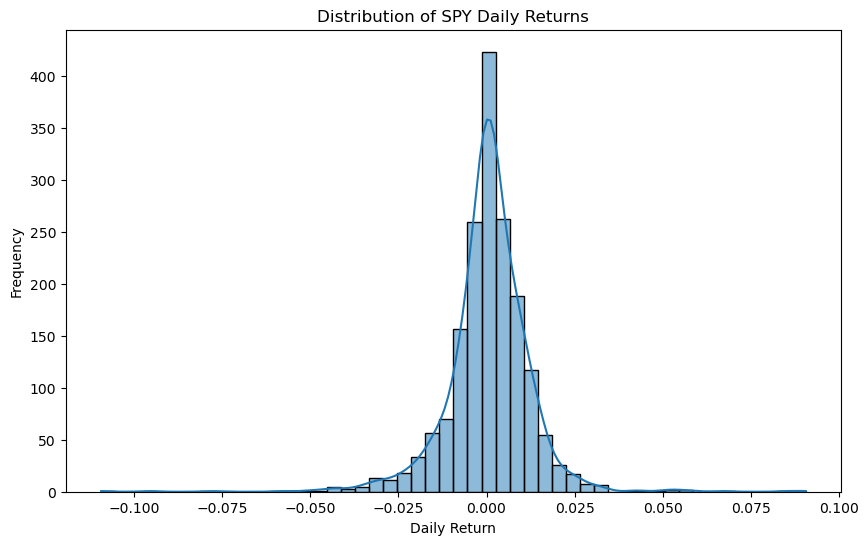

In [12]:
# 2. Visualize the Distribution of Daily Returns
plt.figure(figsize=(10, 6))
sns.histplot(df['daily_return'], bins=50, kde=True)
plt.title('Distribution of SPY Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

- **Explanation:**

  - The histogram, combined with a kernel density estimate (KDE), displays the distribution of SPY's daily returns. This visualization helps us understand the central tendency, spread, and skewness of the returns. 
  - The sharp peak around zero indicates that most daily returns are close to zero, with a few larger positive or negative returns creating the tails of the distribution. 
  - This insight is essential for understanding the general behavior of SPY's price movements and for detecting any potential outliers that could affect the model's predictions.

#### 3. Correlation Matrix
- We then compute the correlation matrix to examine the relationships between the features in our dataset.

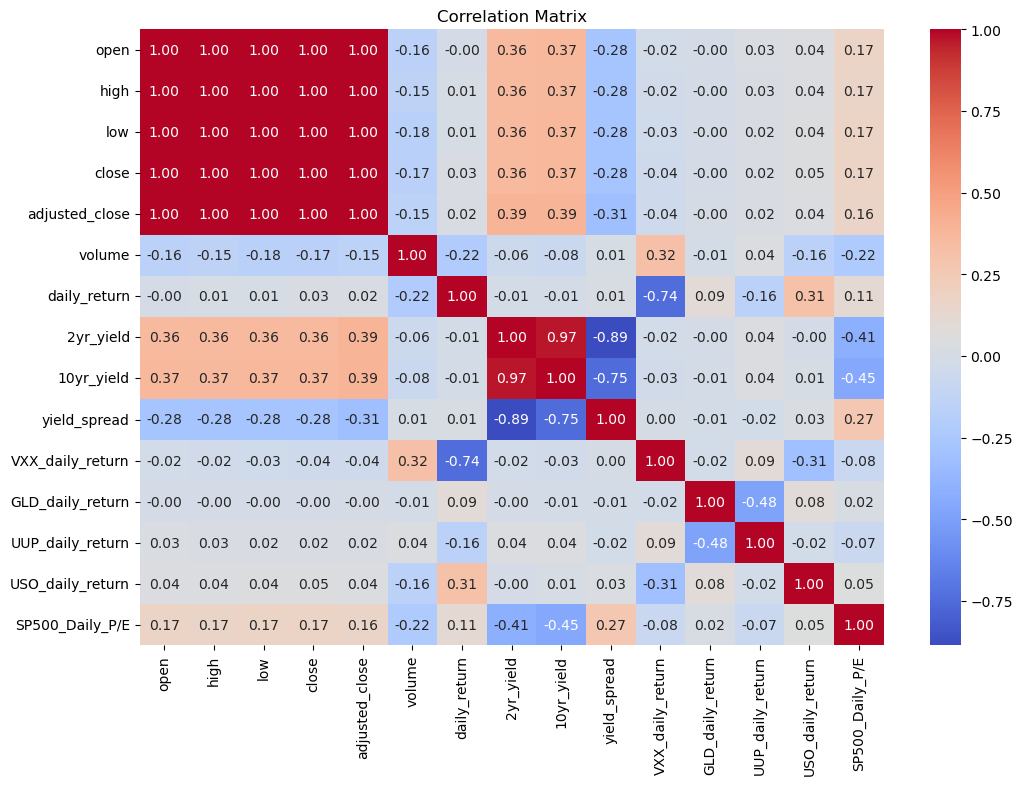

In [13]:
# 3. Correlation Heatmap (Ensure only numeric columns are used)
numeric_df = df.select_dtypes(include='number')
plt.figure(figsize=(12, 8))
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

- **Explanation:**
  - The correlation matrix provides a visual representation of the linear relationships between the various features in the dataset. 
  - Notably, there is a negative correlation between the yield spread and the SPY daily return, suggesting that as the yield spread increases, the SPY ETF's daily return tends to decrease. 
  - Additionally, VXX daily returns show a strong negative correlation with SPY daily returns, reflecting the inverse relationship between market volatility (VXX) and equity performance. 
  - These insights are crucial for understanding how different macroeconomic indicators and market factors interact with the SPY ETF's price movements.

#### 4. Key Pair Plots
- Finally, we create pair plots to visualize the relationships between selected key features.

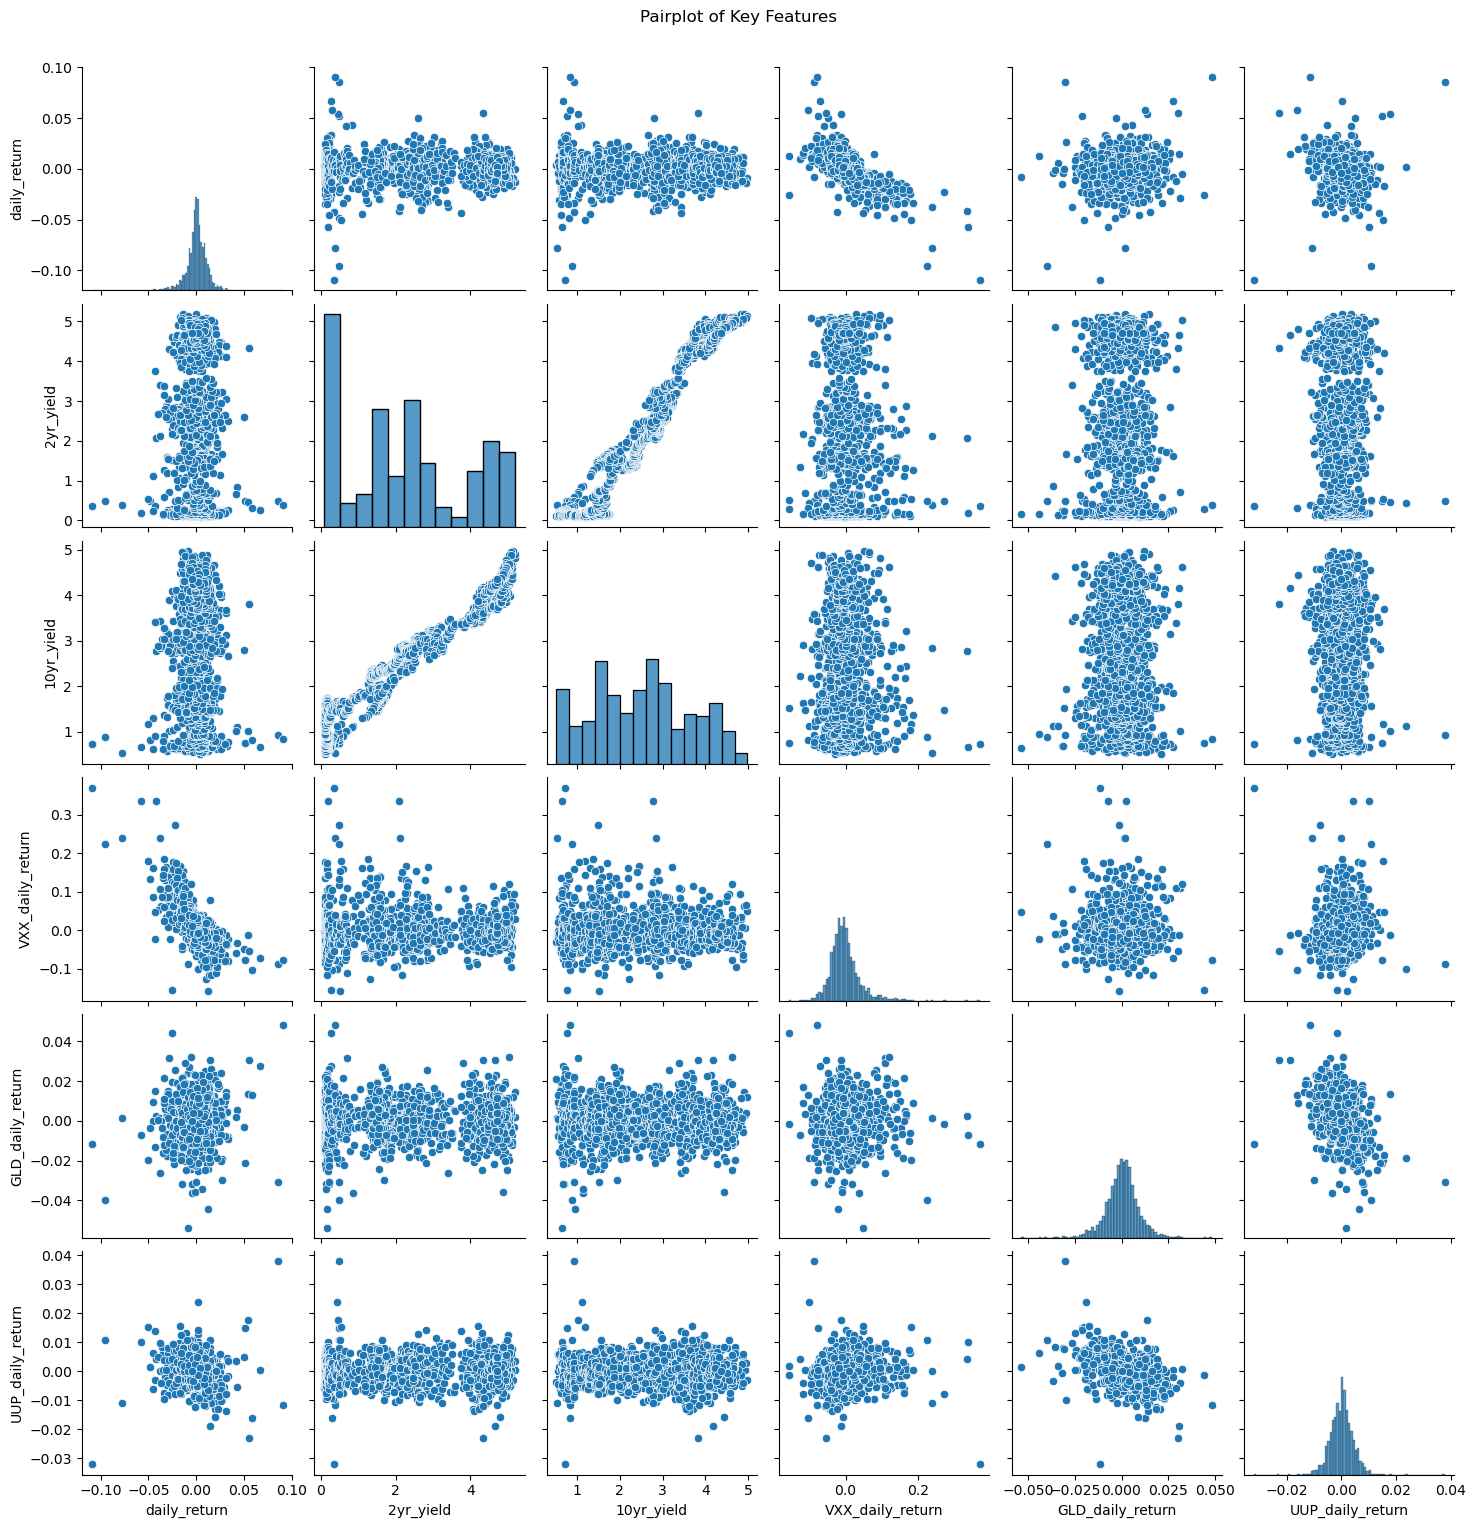

In [14]:
# 4. Pairplot for Key Features
sns.pairplot(numeric_df[['daily_return', '2yr_yield', '10yr_yield', 'VXX_daily_return', 'GLD_daily_return', 'UUP_daily_return']])
plt.suptitle('Pairplot of Key Features', y=1.02)
plt.show()

- **Explanation:**
   - The pair plot provides a visual overview of the relationships between key features in the dataset. Each scatter plot represents the relationship between two features, while the diagonal shows the distribution of individual features. 
   - The plot highlights the linear relationship between the 2-year and 10-year Treasury yields, indicating that they move closely together. 
   - Additionally, the scatter plots show the dispersion and potential correlations between other features like VXX daily returns and SPY daily returns, offering insights into how these variables interact. This visualization is valuable for detecting potential patterns, trends, and outliers that might influence the predictive model.

###   Feature Extraction - Technical Indicators

- In this step, we utilize the pandas_ta library to extract a comprehensive set of technical indicators from the SPY ETF's OHLCV (Open, High, Low, Close, Volume) data. 
- Technical indicators such as moving averages, RSI, MACD, and others provide critical insights into price momentum, volatility, and market trends. 


In [15]:
# Load the data from CSV
data = pd.read_csv('SPY_Final_Dataset.csv', index_col='date', parse_dates=True)

# Create a new DataFrame with OHLC and volume data for calculating technical indicators
ohlcv_data = data[['open', 'high', 'low', 'close', 'volume']]

ohlcv_data.ta.study('All')

In [16]:
ohlcv_data.columns.to_list()

['open',
 'high',
 'low',
 'close',
 'volume',
 'ABER_ZG_5_15',
 'ABER_SG_5_15',
 'ABER_XG_5_15',
 'ABER_ATR_5_15',
 'ACCBL_20',
 'ACCBM_20',
 'ACCBU_20',
 'AD',
 'ADOSC_3_10',
 'ADX_14',
 'ADXR_14_2',
 'DMP_14',
 'DMN_14',
 'AGj_13_8_5',
 'AGt_13_8_5',
 'AGl_13_8_5',
 'ALMA_9_6.0_0.85',
 'ALPHAT_14_1_50',
 'ALPHATl_14_1_50_2',
 'AMATe_LR_8_21_2',
 'AMATe_SR_8_21_2',
 'AO_5_34',
 'OBV',
 'OBV_min_2',
 'OBV_max_2',
 'OBVe_4',
 'OBVe_12',
 'AOBV_LR_2',
 'AOBV_SR_2',
 'APO_12_26',
 'AROOND_14',
 'AROONU_14',
 'AROONOSC_14',
 'ATRr_14',
 'ATRTSe_14_20_3.0',
 'BBL_5_2.0',
 'BBM_5_2.0',
 'BBU_5_2.0',
 'BBB_5_2.0',
 'BBP_5_2.0',
 'BIAS_SMA_26',
 'BOP',
 'AR_26',
 'BR_26',
 'CCI_14_0.015',
 'CDL_2CROWS',
 'CDL_3BLACKCROWS',
 'CDL_3INSIDE',
 'CDL_3LINESTRIKE',
 'CDL_3OUTSIDE',
 'CDL_3STARSINSOUTH',
 'CDL_3WHITESOLDIERS',
 'CDL_ABANDONEDBABY',
 'CDL_ADVANCEBLOCK',
 'CDL_BELTHOLD',
 'CDL_BREAKAWAY',
 'CDL_CLOSINGMARUBOZU',
 'CDL_CONCEALBABYSWALL',
 'CDL_COUNTERATTACK',
 'CDL_DARKCLOUDCOVER',
 'CD

- **Explanation:**
    
  - The 340 technical indicators generated by the pandas_ta library serve as a comprehensive toolkit for understanding and predicting market movements. 
  - By incorporating these indicators into the dataset, we aim to capture various market dynamics, which will ultimately improve the model's ability to forecast the SPY ETF's daily trend.

In [17]:
# Merge the technical indicators back into the original DataFrame
data = data.join(ohlcv_data, how='outer', rsuffix='_tech')

In [18]:
data

open        high         low       close  adjusted_close  \
date                                                                         
2017-07-05  242.630005  243.009995  241.699997  242.770004      215.839382   
2017-07-06  241.889999  242.029999  240.339996  240.550003      213.865647   
2017-07-07  241.210007  242.279999  240.559998  242.110001      215.252593   
2017-07-10  241.950000  242.800000  241.760000  242.370000      215.483751   
2017-07-11  242.160000  242.550000  240.850000  242.190000      215.323718   
...                ...         ...         ...         ...             ...   
2024-06-24  544.330000  546.950000  542.620000  542.740000      542.740000   
2024-06-25  543.990000  545.200000  542.440000  544.830000      544.830000   
2024-06-26  543.690000  546.240000  543.030000  545.510000      545.510000   
2024-06-27  545.370000  546.960000  544.610000  546.370000      546.370000   
2024-06-28  547.160000  550.280000  542.950000  544.220000      544.220000   

                volume  daily_return  2yr_yield  10yr_yield  yield_spread  \
date                                                                        
2017-07-05  54427600.0      0.002312       1.41        2.33          0.92   
2017-07-06  65400800.0     -0.009144       1.40        2.37          0.97   
2017-07-07  56062000.0      0.006485       1.40        2.39          0.99   
2017-07-10  36663274.0      0.001074       1.40        2.38          0.98   
2017-07-11  50290920.0     -0.000743       1.37        2.37          1.00   
...                ...           ...        ...         ...           ...   
2024-06-24  45528654.0     -0.003251       4.71        4.25         -0.46   
2024-06-25  38273346.0      0.003851       4.65        4.23         -0.42   
2024-06-26  38550637.0      0.001248       4.71        4.32         -0.39   
2024-06-27  35041480.0      0.001577       4.70        4.29         -0.41   
2024-06-28  76144535.0     -0.003935       4.71        4.36         -0.35   

            ...    TSVs_18_10  TSVr_18_10       WCP   WILLR_14      WMA_10  \
date        ...                                                              
2017-07-05  ...           NaN         NaN  242.5625        NaN         NaN   
2017-07-06  ...           NaN         NaN  240.8675        NaN         NaN   
2017-07-07  ...           NaN         NaN  241.7650        NaN         NaN   
2017-07-10  ...           NaN         NaN  242.3250        NaN         NaN   
2017-07-11  ...           NaN         NaN  241.9450        NaN         NaN   
...         ...           ...         ...       ...        ...         ...   
2024-06-24  ...  8.515755e+08    0.954749  543.7625 -29.332273  544.424727   
2024-06-25  ...  8.800039e+08    1.205323  544.3250 -24.725865  544.774909   
2024-06-26  ...  9.611370e+08    1.299584  545.0725 -25.511898  545.082000   
2024-06-27  ...  9.686992e+08    0.874445  546.0775 -20.752629  545.389818   
2024-06-28  ...  9.574956e+08    0.692665  545.4175 -33.241909  545.215636   

            ZIGZAGs_5.0%_10  ZIGZAGv_5.0%_10  ZIGZAGd_5.0%_10   ZL_EMA_10  \
date                                                                        
2017-07-05              NaN              NaN              NaN         NaN   
2017-07-06              NaN              NaN              NaN         NaN   
2017-07-07              NaN              NaN              NaN         NaN   
2017-07-10              NaN              NaN              NaN         NaN   
2017-07-11              NaN              NaN              NaN         NaN   
...                     ...              ...              ...         ...   
2024-06-24              NaN              NaN              NaN  545.867711   
2024-06-25              NaN              NaN              NaN  545.013581   
2024-06-26              NaN              NaN              NaN  544.832930   
2024-06-27              NaN              NaN              NaN  545.450579   
2024-06-28              NaN              NaN              NaN 

###   Choosing the Threshold
  - In this step, we determine the threshold for labeling the target variable. The threshold is set based on the percentiles of the SPY ETF's daily returns, along with its historical volatility (standard deviation). 
  - By analyzing the distribution and calculating the percentiles, we chose a threshold of 0.20% (0.0020) for the daily return. 
  - This threshold is used to label the target variable, where returns above this threshold are classified as positive (1), indicating a potential uptrend, while returns below are classified as negative or neutral (0).

In [19]:
# 1. Calculate Summary Statistics
print("Summary Statistics:")
df['daily_return'].describe()

Summary Statistics:


count    1746.000000
mean        0.000604
std         0.012096
min        -0.109424
25%        -0.004016
50%         0.000785
75%         0.006419
max         0.090603
Name: daily_return, dtype: float64

In [22]:
#2. Calculate Percentiles to Determine Threshold
percentiles = np.percentile(df['daily_return'], [1, 5, 50, 95, 99])
print("\n1st, 5th, 50th, 95th, 99th Percentiles of Daily Returns:")
print(percentiles)


1st, 5th, 50th, 95th, 99th Percentiles of Daily Returns:
[-0.03403047 -0.0177314   0.00078455  0.01614393  0.03002091]


In [23]:
# 3. Calculate Historical Volatility (Standard Deviation)
volatility = df['daily_return'].std()
print("\nHistorical Volatility (Standard Deviation) of SPY Returns:")
print(volatility)

# Set the threshold as a multiple of the standard deviation
threshold = 0.0020 


print(f"Chosen threshold: {threshold}")


Historical Volatility (Standard Deviation) of SPY Returns:
0.012096406015624365
Chosen threshold: 0.002


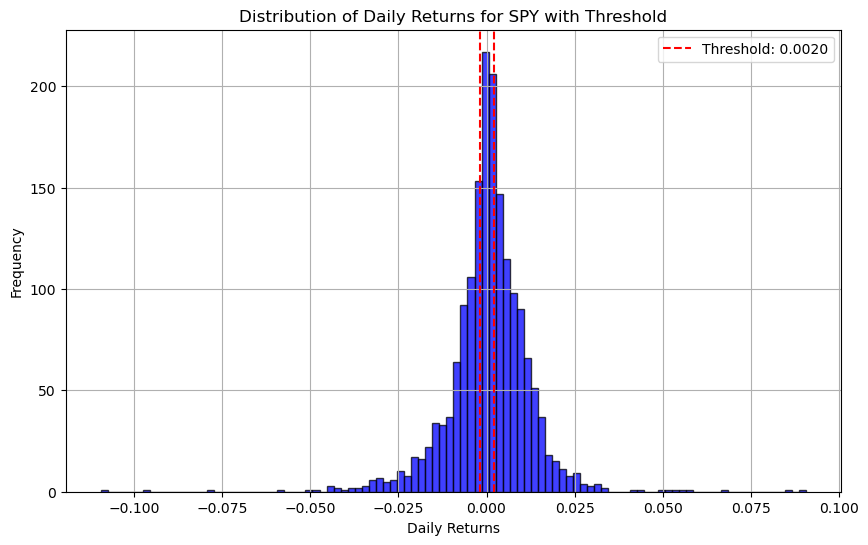

In [24]:
# Visualize the threshold on the histogram
plt.figure(figsize=(10, 6))
plt.hist(df['daily_return'], bins=100, alpha=0.75, color='blue', edgecolor='black')
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.4f}')
plt.axvline(x=-threshold, color='red', linestyle='--')
plt.title('Distribution of Daily Returns for SPY with Threshold')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

- **Explanation:**
  - The chosen threshold helps distinguish between significant and insignificant daily returns. By setting the threshold at 0.20%, we focus on capturing meaningful price movements that indicate a potential trend, which is critical for building an accurate and effective predictive model.

### Target Labeling

- The label or the target variable is also known as the dependent variable. In this project, the target variable is defined as whether the S\&P 500 ETF (SPY) will experience a significant positive return based on a threshold of 0.20% in its daily return. If the daily return exceeds this threshold, the label is set to +1 (indicating a buy signal). Otherwise, it is set to 0. The target can be mathematically described as:

$$
y_t = 
\begin{cases} 
1, & \text{if } r_t > 0.002 \\
0, & \text{otherwise}
\end{cases}
$$

- where \( r_t \) is the daily return of the SPY ETF on day \( t \), calculated as:

$$
r_t = \frac{P_t - P_{t-1}}{P_{t-1}}
$$

- Here, $( P_t )$ is the closing price of SPY on day $( t )$, and $( P_{t-1}) $ is the closing price on the previous trading day.

- The target variable $( y_t )$ is then used in the model to predict whether the SPY ETF's price will increase significantly based on the defined threshold.




In [25]:
# 1. Define the Target (Label) Using Threshold
threshold = 0.0020  # Define your threshold (0.20%)
data['Target'] = np.where(data['daily_return'] > threshold, 1, 0)

# 2. Backfill missing values to address missing data
data = data.bfill(axis=1)

# 3. Remove any remaining rows with NaN values (if needed)
data.dropna(inplace=True)

# 4. Check for missing values to ensure they're handled
print(data.isna().sum())


open               0
high               0
low                0
close              0
adjusted_close     0
                  ..
ZIGZAGv_5.0%_10    0
ZIGZAGd_5.0%_10    0
ZL_EMA_10          0
ZS_30              0
Target             0
Length: 356, dtype: int64


In [26]:
# 6. Save the cleaned dataset
data.to_csv('SPY_All_Features.csv')

In [27]:
data.head()

open        high         low       close  adjusted_close  \
date                                                                         
2017-07-05  242.630005  243.009995  241.699997  242.770004      215.839382   
2017-07-06  241.889999  242.029999  240.339996  240.550003      213.865647   
2017-07-07  241.210007  242.279999  240.559998  242.110001      215.252593   
2017-07-10  241.950000  242.800000  241.760000  242.370000      215.483751   
2017-07-11  242.160000  242.550000  240.850000  242.190000      215.323718   

                volume  daily_return  2yr_yield  10yr_yield  yield_spread  \
date                                                                        
2017-07-05  54427600.0      0.002312       1.41        2.33          0.92   
2017-07-06  65400800.0     -0.009144       1.40        2.37          0.97   
2017-07-07  56062000.0      0.006485       1.40        2.39          0.99   
2017-07-10  36663274.0      0.001074       1.40        2.38          0.98   
2017-07-11  50290920.0     -0.000743       1.37        2.37          1.00   

            ...  TSVr_18_10       WCP  WILLR_14  WMA_10  ZIGZAGs_5.0%_10  \
date        ...                                                            
2017-07-05  ...    242.5625  242.5625       1.0     1.0              1.0   
2017-07-06  ...    240.8675  240.8675       0.0     0.0              0.0   
2017-07-07  ...    241.7650  241.7650       1.0     1.0              1.0   
2017-07-10  ...    242.3250  242.3250       0.0     0.0              0.0   
2017-07-11  ...    241.9450  241.9450       0.0     0.0              0.0   

            ZIGZAGv_5.0%_10  ZIGZAGd_5.0%_10  ZL_EMA_10  ZS_30  Target  
date                                                                    
2017-07-05              1.0              1.0        1.0    1.0     1.0  
2017-07-06              0.0              0.0        0.0    0.0     0.0  
2017-07-07              1.0              1.0        1.0    1.0     1.0  
2017-07-10              0.0              0.0        0.0    0.0     0.0  
2017-07-11              0.0              0.0        0.0    0.0     0.0  

[5 rows x 356 columns]

- **Explanation:**
  - The code defines the target variable Target based on the set threshold. The target is labeled as 1 if the daily return exceeds the threshold, otherwise as 0. Additionally, the code handles missing values by backfilling and ensures that any remaining NaN values are removed. This step is crucial for preparing the data for model training, ensuring that it is clean and accurately labeled.

  - This step is correctly implemented and aligns well with the project's objective of predicting the SPY ETF's trend based on historical data.

### Class Imbalance
 - Class imbalance is a common issue in financial datasets where the occurrence of one class significantly outweighs the other. 
 - In this project, we observe that the number of days with significant positive returns (Target = 1) is lower than those with neutral or negative returns (Target = 0). 
 - To address this imbalance, we calculate class weights that will be applied during model training to ensure that both classes are given equal importance. 
 - These weights are inversely proportional to the class frequencies, allowing the model to treat the minority class with greater emphasis.

In [28]:
# class frequency
c = data['Target'].value_counts()
c

Target
0.0    993
1.0    753
Name: count, dtype: int64

In [29]:
# Class Imbalance Handling
def cwts(dfs):
    c0, c1 = np.bincount(dfs['Target'])
    w0 = (1/c0) * (len(dfs)) / 2
    w1 = (1/c1) * (len(dfs)) / 2
    return {0: w0, 1: w1}

class_weight = cwts(data)
print(f"Class Weights: {class_weight}")


Class Weights: {0: 0.879154078549849, 1: 1.1593625498007967}


In [30]:
class_weight[0] * c[0], class_weight[1] * c[1]

(873.0, 872.9999999999999)

---

### Feature Selection and Transformations



#### Multicollinearity Analysis Using Variance Inflation Factor (VIF) on All Feature Set 

- Multicollinearity occurs when two or more features in the dataset are highly correlated, leading to redundancy and potentially skewing the model's results. To address this issue, we perform a multicollinearity analysis using the Variance Inflation Factor (VIF). VIF quantifies how much the variance of a regression coefficient is inflated due to multicollinearity among the features.

- In this step, VIF is calculated for all features, and features with Inf or NaN VIF values are iteratively removed from the dataset. This ensures that the remaining features are more independent of each other, which helps in improving the model's stability and interpretability.

In [31]:
# Step 1: Prepare the data for VIF calculation (excluding the Target column)
X_vif = data.drop(columns=['Target'])

# Step 2: Add a constant column for the VIF calculation
X_vif = sm.add_constant(X_vif)

# Function to calculate VIF and drop columns with inf or NaN VIF values
def calculate_vif_and_clean(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    # Identify and drop features with inf or NaN VIF values
    features_to_drop = vif_data[vif_data["VIF"].isin([float('inf'), float('nan')])]["Feature"]
    X_cleaned = X.drop(columns=features_to_drop)
    
    return X_cleaned, vif_data.sort_values(by="VIF", ascending=False)

# Iteratively drop features with inf or NaN VIF values
while True:
    X_vif, vif_data_cleaned = calculate_vif_and_clean(X_vif)
    
    # Break the loop if no more inf or NaN VIF values are present
    if not vif_data_cleaned["VIF"].isin([float('inf'), float('nan')]).any():
        break

# Step 3: Remove the constant column (optional)
X_vif = X_vif.drop(columns=['const'], errors='ignore')

# Step 4: Update the data by dropping the identified features and include the Target column
data_after_VIF = data[X_vif.columns].copy()
data_after_VIF['Target'] = data['Target']

# Step 5: Save the cleaned data to a new CSV file
data_after_VIF.to_csv('SPY_data_after_VIF.csv', index=True)

# Display the final cleaned VIF results
vif_data_cleaned

Feature       VIF
327            VHM_610  1.058060
113      CDL_TASUKIGAP  1.006239
89        CDL_HIGHWAVE  1.002550
109    CDL_SPINNINGTOP  1.001606
248  REFLEX_20_20_0.04  1.000021
..                 ...       ...
148            ENTP_10  0.008357
124              CG_10  0.007231
211              NVI_1  0.005617
233                PVI  0.000086
0                const  0.000000

[343 rows x 2 columns]

In [32]:
data_after_VIF

open        high         low       close  adjusted_close  \
date                                                                         
2017-07-05  242.630005  243.009995  241.699997  242.770004      215.839382   
2017-07-06  241.889999  242.029999  240.339996  240.550003      213.865647   
2017-07-07  241.210007  242.279999  240.559998  242.110001      215.252593   
2017-07-10  241.950000  242.800000  241.760000  242.370000      215.483751   
2017-07-11  242.160000  242.550000  240.850000  242.190000      215.323718   
...                ...         ...         ...         ...             ...   
2024-06-24  544.330000  546.950000  542.620000  542.740000      542.740000   
2024-06-25  543.990000  545.200000  542.440000  544.830000      544.830000   
2024-06-26  543.690000  546.240000  543.030000  545.510000      545.510000   
2024-06-27  545.370000  546.960000  544.610000  546.370000      546.370000   
2024-06-28  547.160000  550.280000  542.950000  544.220000      544.220000   

                volume  daily_return  2yr_yield  10yr_yield  yield_spread  \
date                                                                        
2017-07-05  54427600.0      0.002312       1.41        2.33          0.92   
2017-07-06  65400800.0     -0.009144       1.40        2.37          0.97   
2017-07-07  56062000.0      0.006485       1.40        2.39          0.99   
2017-07-10  36663274.0      0.001074       1.40        2.38          0.98   
2017-07-11  50290920.0     -0.000743       1.37        2.37          1.00   
...                ...           ...        ...         ...           ...   
2024-06-24  45528654.0     -0.003251       4.71        4.25         -0.46   
2024-06-25  38273346.0      0.003851       4.65        4.23         -0.42   
2024-06-26  38550637.0      0.001248       4.71        4.32         -0.39   
2024-06-27  35041480.0      0.001577       4.70        4.29         -0.41   
2024-06-28  76144535.0     -0.003935       4.71        4.36         -0.35   

            ...  TSVr_18_10       WCP   WILLR_14      WMA_10  ZIGZAGs_5.0%_10  \
date        ...                                                                 
2017-07-05  ...  242.562500  242.5625   1.000000    1.000000         1.000000   
2017-07-06  ...  240.867500  240.8675   0.000000    0.000000         0.000000   
2017-07-07  ...  241.765000  241.7650   1.000000    1.000000         1.000000   
2017-07-10  ...  242.325000  242.3250   0.000000    0.000000         0.000000   
2017-07-11  ...  241.945000  241.9450   0.000000    0.000000         0.000000   
...         ...         ...       ...        ...         ...              ...   
2024-06-24  ...    0.954749  543.7625 -29.332273  544.424727       545.867711   
2024-06-25  ...    1.205323  544.3250 -24.725865  544.774909       545.013581   
2024-06-26  ...    1.299584  545.0725 -25.511898  545.082000       544.832930   
2024-06-27  ...    0.874445  546.0775 -20.752629  545.389818       545.450579   
2024-06-28  ...    0.692665  545.4175 -33.241909  545.215636       545.495928   

            ZIGZAGv_5.0%_10  ZIGZAGd_5.0%_10   ZL_EMA_10     ZS_30  Target  
date                                                                        
2017-07-05         1.000000         1.000000    1.000000  1.000000     1.0  
2017-07-06         0.000000         0.000000    0.000000  0.000000     0.0  
2017-07-07         1.000000         1.000000    1.000000  1.000000     1.0  
2017-07-10         0.000000         0.000000    0.000000  0.000000     0.0  
2017-07-11         0.000000         0.000000    0.000000  0.000000     0.0  
...                     ...              ...         ...       ...     ...  
2024-06-24       545.867711       545.867711  545.867711  1.205331     0.0  
2024-06-25       545.013581       545.013581  545.013581  1.379503     1.0  
2024-06-26       544.832930       544.832930  544.832930  1.382576     0.0  
2024-06-27       545.450579       545.450579  545.450579  1.399714     0.0  
2024-06-28       545.49

- **Explanation:**
   - This process helps in identifying and removing features that contribute to multicollinearity, ensuring that the remaining features in the dataset are more independent and contribute uniquely to the model.
   - By applying VIF to the entire feature set and removing those with Inf or NaN values, we enhance the model's performance by reducing redundancy and the risk of overfitting.

---

### Feature Selection using RFE (Recursive Feature Elimination)

- **SVC-RFE (Support Vector Classifier - Recursive Feature Elimination):**
  - We use SVC-RFE to iteratively remove the least important features, based on the model's performance. 
  - This method ranks features according to their importance in predicting the target variable, retaining only those that contribute most to the model’s accuracy. 
  - SVC-RFE helps in reducing the feature space, making the model more efficient and easier to interpret.

In [33]:
# Step 1: Load the entire dataset
data_all = pd.read_csv('SPY_data_after_VIF.csv', index_col=0)

# Step 2: Define feature matrix X and target vector y
X = data_all.drop(columns=['Target'])
y = data_all['Target']

# Step 3: Split the data into training and testing sets (keeping shuffle=False for time series)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [34]:
# Step 4: Custom class weight function
def cwts(y):
    c0, c1 = np.bincount(y)  # Count occurrences of each class
    w0 = (1/c0) * len(y) / 2
    w1 = (1/c1) * len(y) / 2
    return {0: w0, 1: w1}

# Calculate class weights using the custom function
class_weight = cwts(y_train)
print("Class Weights:", class_weight)

Class Weights: {0: 0.8880407124681935, 1: 1.1442622950819672}


####  Apply MinMax Scaling
 - In this step, the features are scaled using MinMaxScaler, which scales each feature to a given range, typically between 0 and 1. 
 - This is crucial for ensuring that all features contribute equally to the model's performance, particularly for models like SVM that are sensitive to the scale of the input data.

In [35]:
# Step 5: Apply MinMax Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

- **Explanation:**
  - The training and testing datasets are scaled, ensuring that all features are within the range [0, 1], which helps in improving the model’s convergence and performance.

#### Define a Range of C Values to Explore
  - Here, we define a range of C values, which is a hyperparameter for the SVM model. 
  - The C parameter controls the trade-off between achieving a low error on the training data and minimizing the model's complexity.

In [37]:
# Define a range of C values to explore
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

- A dictionary param_grid that contains the range of C values to be explored during the hyperparameter tuning.

#### Initialize the SVM with a Linear Kernel
   -  An SVM classifier is initialized with a linear kernel. 
   - The class_weight parameter is set to handle class imbalance, giving more weight to the minority class.

In [38]:
# Initialize the SVM with a linear kernel
svc = SVC(kernel="linear", random_state=42, class_weight=class_weight)

####  Perform Grid Search with Cross-Validation
  - Grid Search with Cross-Validation is performed to identify the best C value from the defined range.
  - Cross-validation ensures that the model is validated on different subsets of the data, reducing the risk of overfitting.

In [39]:
# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_}")

Best Parameters: {'C': 1}
Best Cross-Validation Accuracy: 0.9047388632872504


- **Output:**

  - **Best Parameters: { 'C': 1 }**
  - **Best Cross-Validation Accuracy: 0.9047388632872504**
  - These outputs indicate that the optimal value for the C parameter is 1, and the model achieved a cross-validation accuracy of approximately 90.47%.

#### Perform RFE to Select Top Features
   -  In this step, we apply Recursive Feature Elimination (RFE) using the best SVC model obtained from the grid search. 
   - RFE works by recursively removing the least important features and building the model with the remaining ones.    - The process continues until the specified number of features is selected. Here, we aim to select the top 50 features from the dataset.

In [40]:
# Perform RFE to select top features
rfe = RFE(estimator=best_model, n_features_to_select=50, step=10)
rfe.fit(X_train_scaled, y_train)


RFE(estimator=SVC(C=1,
                  class_weight={0: 0.8880407124681935, 1: 1.1442622950819672},
                  kernel='linear', random_state=42),
    n_features_to_select=50, step=10)

- The RFE process completes using the SVC model, identifying the top 50 most important features based on their contribution to the model's performance.

#### Select Features Using RFE
  -  After fitting the RFE model, the top features are selected from both the training and testing datasets. This step ensures that only the most relevant features, as identified by RFE, are used in the final model.

In [41]:
# Select features using RFE
X_train_rfe = rfe.transform(X_train_scaled)
X_test_rfe = rfe.transform(X_test_scaled)

- The training and testing datasets are now reduced to only the top 50 features selected by RFE, which are expected to contribute the most to the model’s accuracy.

**Print RFE Feature Ranking:**
  - After performing Recursive Feature Elimination (RFE), we print the ranking of all features. The ranking provided by RFE indicates the importance of each feature, where a rank of 1 signifies that the feature has been selected as one of the top features.

In [42]:
# Print the features selected by RFE
selected_features = X.columns[rfe.support_]
print("Selected Features by RFE:")
selected_features

Selected Features by RFE:


Index(['volume', 'daily_return', 'yield_spread', 'VXX_daily_return',
       'UUP_daily_return', 'volume_tech', 'ADOSC_3_10', 'ADX_14', 'OBV',
       'OBVe_4', 'AOBV_SR_2', 'BBP_5_2.0', 'BOP', 'BR_26', 'CCI_14_0.015',
       'CDL_HAMMER', 'CDL_HANGINGMAN', 'CDL_HARAMI', 'CDL_INNECK',
       'CDL_INSIDE', 'CDL_MARUBOZU', 'CDL_MATCHINGLOW', 'DEC_1', 'BULLP_13',
       'INC_1', 'KVO_34_55_13', 'PDIST', 'PCTRET_1', 'PGO_14',
       'PIVOTS_TRAD_D_P', 'PIVOTS_TRAD_D_R1', 'PIVOTS_TRAD_D_R2',
       'PIVOTS_TRAD_D_R3', 'PIVOTS_TRAD_D_R4', 'PPO_12_26_9', 'PSL_12', 'PVI',
       'PVIe_255', 'PVO_12_26_9', 'PVOL', 'PVT', 'SLOPE_1', 'SMCtp_14_50_20_5',
       'SMIs_5_20_5_1.0', 'SQZ_20_2.0_20_1.5', 'SQZ_NO',
       'SQZPRO_20_2.0_20_2.0_1.5_1.0', 'SQZPRO_NO', 'STDEV_30', 'TMO_14_5_3'],
      dtype='object')

In [43]:
# Print RFE Ranking of Features
print("RFE Feature Ranking (1 indicates selected features):")
rfe.ranking_

RFE Feature Ranking (1 indicates selected features):


array([27, 28, 22, 26, 29,  1,  1, 17, 18,  1,  1,  6,  1,  3, 12, 27, 27,
       21, 26,  1, 18, 24, 24, 24, 25, 25, 25, 13,  1,  1, 17, 18, 17, 19,
       20, 22, 16, 28, 23,  3, 29, 13,  1, 12,  5,  1, 12,  9,  1, 26,  9,
        5, 15, 22, 19, 27, 28, 23, 16,  1, 27,  1,  5,  1,  1, 31, 18, 31,
        9, 31,  3, 13, 31,  7, 19, 30, 14,  8,  6,  8, 30, 30, 13, 23,  1,
        1,  1,  3,  3, 13, 31, 13,  1,  1, 31, 31,  4, 11,  1,  1, 31, 31,
        3, 11,  5, 30, 10,  3, 19, 30, 31,  6, 25,  4,  3,  4, 30, 30, 17,
        5, 19,  8,  8,  4, 25, 12, 14, 20, 20, 20, 20, 20, 20, 20, 20, 22,
       22, 18,  1, 25, 14, 23, 17, 30,  4, 12,  9, 10,  7,  8,  1, 14,  3,
        8, 18, 18, 17, 13, 24, 25, 28,  9,  9, 19, 26, 26, 22,  7, 15,  8,
       21, 15, 16, 19, 30,  7,  6, 14, 14,  1, 19, 23, 29, 19, 17, 23, 25,
       20, 22, 11, 14, 28,  1,  6, 21, 23, 29, 29, 29, 23, 30, 27, 12, 29,
       21, 29, 24, 27,  8, 15, 15, 28,  1,  1,  1,  1,  7, 11, 11, 11,  1,
        1,  1,  1,  1,  4

- The output array shows the ranking of all features. Features with a ranking of 1 are the ones selected by RFE, while other features have higher ranks and are not part of the final selected feature set.

#### Retrain the Model on the Selected Features
 - After selecting the top features using RFE, we retrain the Support Vector Classifier (SVC) model on the reduced feature set. 
 - This step ensures that the model is optimized based on the most relevant features identified earlier.

In [44]:
# Retrain the model on the selected features
best_model.fit(X_train_rfe, y_train)

SVC(C=1, class_weight={0: 0.8880407124681935, 1: 1.1442622950819672},
    kernel='linear', random_state=42)

- The SVC model is successfully retrained using the selected features, with the best parameters and class weights applied. The model is now ready for evaluation.

#### Evaluate the Model on the Training Set
  - Once the model is retrained, we evaluate its performance on the training set. 
  - The evaluation includes calculating the accuracy, AUC (Area Under the ROC Curve), and generating a classification report that includes precision, recall, and F1-score for both classes.

In [46]:
#Evaluate the model on the training set
y_train_pred = best_model.predict(X_train_rfe)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, best_model.decision_function(X_train_rfe))

print(f"Training Accuracy: {train_accuracy}")
print(f"Training AUC: {train_auc}")
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

Training Accuracy: 0.9262177650429799
Training AUC: 0.9877424602678012
Training Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.88      0.93       786
         1.0       0.87      0.98      0.92       610

    accuracy                           0.93      1396
   macro avg       0.93      0.93      0.93      1396
weighted avg       0.93      0.93      0.93      1396




**Explanation:**  
  - The model demonstrates strong performance on the training set, with a high accuracy of approximately `92.62%` and an impressive AUC of `0.9877`, indicating excellent classification ability. 
  - The classification report shows high precision, recall, and F1-scores for both classes, confirming that the model is well-calibrated and performs well in distinguishing between the two target classes.
  - This sequence of steps is essential for validating the effectiveness of the feature selection process and ensuring that the model is both accurate and reliable before moving on to testing and further evaluation.


#### Step-3.2.9) Evaluate the Model on the Test Set
  - After successfully evaluating the model on the training set, the next step is to assess its performance on the test set. This step includes calculating the accuracy, AUC (Area Under the ROC Curve), and generating a classification report with precision, recall, and F1-score metrics for both classes.

In [47]:
#Evaluate the model on the test set
y_test_pred = best_model.predict(X_test_rfe)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, best_model.decision_function(X_test_rfe))


print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

Test Accuracy: 0.88
Test AUC: 0.9761156717678456
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.81      0.89       207
         1.0       0.78      0.98      0.87       143

    accuracy                           0.88       350
   macro avg       0.88      0.90      0.88       350
weighted avg       0.90      0.88      0.88       350



**Explanation:**  
 - The model demonstrates strong performance on the test set, achieving an accuracy of `88%` and an impressive AUC of `0.9761`. 
 - The classification report shows that the model is well-balanced, with high precision, recall, and F1-scores for both classes. These results indicate that the model generalizes well to unseen data, making it reliable for real-world predictions.


#### Plot ROC Curve for the Test Set
 -  Finally, the ROC (Receiver Operating Characteristic) curve is plotted to visually assess the model's performance on the test set. 
 - The ROC curve shows the trade-off between the true positive rate and false positive rate at various threshold settings, with the AUC representing the overall performance.


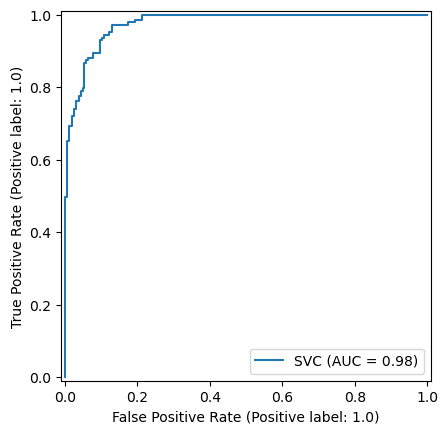

In [48]:
# Plot ROC Curve for the test set
RocCurveDisplay.from_estimator(best_model, X_test_rfe, y_test)
plt.show()

- The ROC curve is displayed, providing a visual representation of the model's ability to distinguish between the two classes. The closer the curve follows the top-left corner, the better the model's performance.

#### Save the Selected Features
   - In this final step, the selected features identified through the RFE process are saved into a new CSV file. This allows for easy access and use of the refined dataset in subsequent modeling and analysis steps.

In [49]:
# Extract selected feature names
selected_features = X_train.columns[rfe.support_]

# Create a new DataFrame with only the selected features
data_selected_features = data_all[selected_features]
data_selected_features['Target'] = y

# Save the new dataset with selected features
data_selected_features.to_csv('SPY_Selected_Features.csv', index=True)

data_selected_features

volume  daily_return  yield_spread  VXX_daily_return  \
date                                                                   
2017-07-05  54427600.0      0.002312          0.92          0.000775   
2017-07-06  65400800.0     -0.009144          0.97          0.051123   
2017-07-07  56062000.0      0.006485          0.99         -0.036109   
2017-07-10  36663274.0      0.001074          0.98         -0.024465   
2017-07-11  50290920.0     -0.000743          1.00         -0.003918   
...                ...           ...           ...               ...   
2024-06-24  45528654.0     -0.003251         -0.46         -0.007972   
2024-06-25  38273346.0      0.003851         -0.42         -0.017857   
2024-06-26  38550637.0      0.001248         -0.39         -0.010909   
2024-06-27  35041480.0      0.001577         -0.41         -0.006434   
2024-06-28  76144535.0     -0.003935         -0.35          0.010176   

            UUP_daily_return  volume_tech    ADOSC_3_10      ADX_14  \
date                                                                  
2017-07-05          0.000402   54427600.0  0.000000e+00    0.000000   
2017-07-06         -0.004416   65400800.0  0.000000e+00    0.000000   
2017-07-07          0.001613   56062000.0  0.000000e+00    0.000000   
2017-07-10          0.000403   36663274.0  0.000000e+00    0.000000   
2017-07-11         -0.003622   50290920.0  2.419980e+02  241.998002   
...                      ...          ...           ...         ...   
2024-06-24         -0.003436   45528654.0  3.742017e+07   26.137312   
2024-06-25          0.001034   38273346.0  3.392215e+07   26.493766   
2024-06-26          0.004823   38550637.0  3.609444e+07   27.023626   
2024-06-27         -0.001371   35041480.0  3.925285e+07   27.653751   
2024-06-28          0.000000   76144535.0  2.114413e+07   28.820181   

                     OBV        OBVe_4  ...   SLOPE_1  SMCtp_14_50_20_5  \
date                                    ...                               
2017-07-05  5.442760e+07  0.000000e+00  ...  0.000000         -7.203386   
2017-07-06 -1.097320e+07  0.000000e+00  ... -2.220001         -7.203386   
2017-07-07  4.508880e+07  0.000000e+00  ...  1.559998         -7.203386   
2017-07-10  8.175207e+07  4.257382e+07  ...  0.259999         -7.203386   
2017-07-11  3.146115e+07  3.812875e+07  ... -0.180000         -7.203386   
...                  ...           ...  ...       ...               ...   
2024-06-24  1.641817e+09  1.693174e+09  ... -1.770000         -7.034976   
2024-06-25  1.680090e+09  1.687940e+09  ...  2.090000        -10.189487   
2024-06-26  1.718641e+09  1.700220e+09  ...  0.680000        -20.033204   
2024-06-27  1.753682e+09  1.721605e+09  ...  0.860000        -25.013835   
2024-06-28  1.677537e+09  1.703978e+09  ... -2.150000        -39.769611   

            SMIs_5_20_5_1.0  SQZ_20_2.0_20_1.5  SQZ_NO  \
date                                                     
2017-07-05         0.000000           0.000000     1.0   
2017-07-06         0.000000           0.000000     1.0   
2017-07-07         0.000000           0.000000     1.0   
2017-07-10         0.000000           0.000000     1.0   
2017-07-11         0.000000           0.000000     1.0   
...                     ...                ...     ...   
2024-06-24         0.474321          17.613333     0.0   
2024-06-25         0.445492          16.528333     0.0   
2024-06-26         0.422361          14.363333     0.0   
2024-06-27         0.407246          12.628333     0.0   
2024-06-28         0.381533          10.640000     0.0   

            SQZPRO_20_2.0_20_2.0_1.5_1.0  SQZPRO_NO  STDEV_30  TMO_14_5_3  \
date                                                                        
2017-07-05                      0.000000        1.0  0.000000    0.000000   
2017-07-06                      0.000000        1.0  1.360001    0.000000   
2017-07-07                      0.000000        1.0  0.250000    0.000000   
2017-07-10                      0.00000

###  SOM 

  - Self-Organizing Maps (SOM) is an unsupervised learning technique that is particularly useful for dimensionality reduction, clustering, and visualizing high-dimensional data. 
  - SOMs project high-dimensional input data onto a lower-dimensional grid (usually 2D), preserving the topological structure of the data. T
  - This means that similar data points are mapped close to each other on the grid, making it easier to identify clusters and patterns.

In [50]:
# Set seed for reproducibility
random.seed(2024)
np.random.seed(2024)

# Load the new dataset with selected features
data_selected_features = pd.read_csv('SPY_Selected_Features.csv', index_col=0)

# Define feature matrix X (excluding the 'Target' column)
X_som = data_selected_features.drop(columns=['Target'])

# Transform feature matrix using MinMaxScaler
scaler = MinMaxScaler()
X_som_scaled = scaler.fit_transform(X_som)

# Convert target to integer type if it's float
target = data_selected_features['Target'].astype(int).values

- The 20x20 grid size is chosen to ensure that the SOM can effectively map the complex, high-dimensional feature space of the dataset, capturing detailed clusters while maintaining interpretability and computational efficiency. 

- This grid size provides a robust structure for identifying patterns and relationships within the data, making it a well-suited choice for this project.

In [51]:
# Define the size of the SOM grid
som_size_x = 20
som_size_y = 20

print(f"SOM Grid Size: {som_size_x}x{som_size_y}")

SOM Grid Size: 20x20


- Initialize and Train the SOM

In [52]:
# Initialize the SOM
som = MiniSom(x=som_size_x, y=som_size_y, input_len=X_som_scaled.shape[1], sigma=5.0, learning_rate=0.5, random_seed=42)

# Train the SOM
som.train_random(data=X_som_scaled, num_iteration=1000)

**Plot the U-Matrix (Unified Distance Matrix):**
 - The U-Matrix is a visualization tool used in SOM to show the distances between the neurons. Areas of the U-Matrix with larger distances indicate potential cluster boundaries.

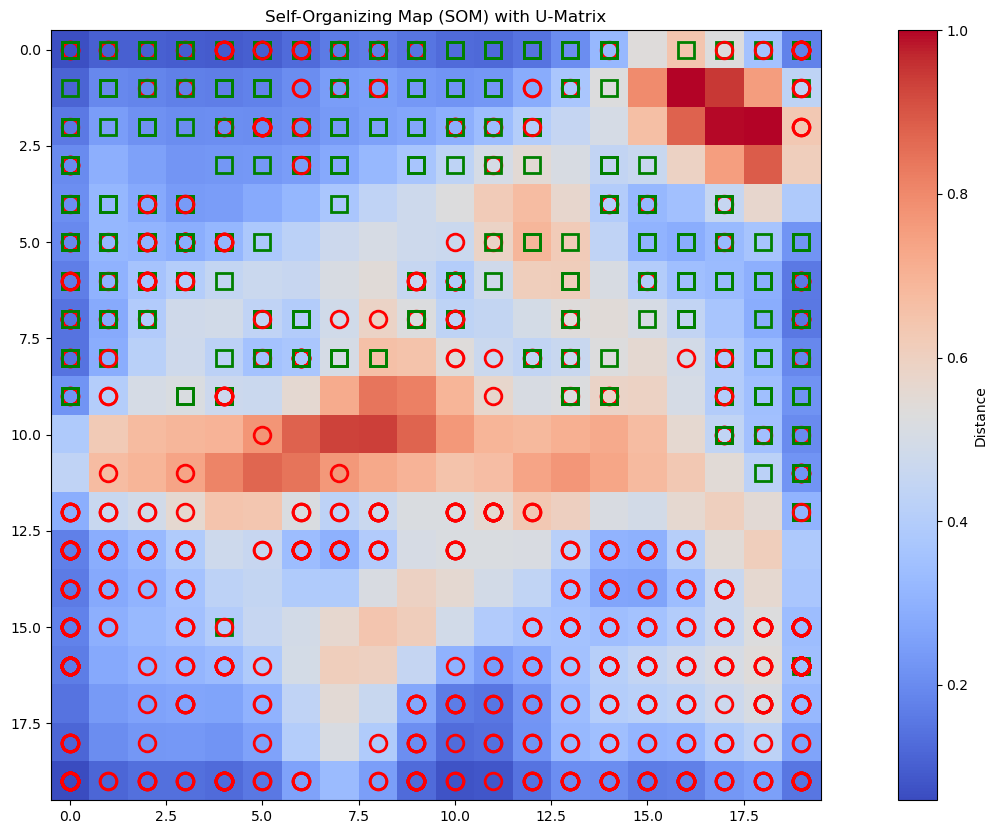

In [53]:
# Create a U-Matrix (Unified Distance Matrix) to visualize the clusters
u_matrix = som.distance_map().T

# Plot the U-Matrix
plt.figure(figsize=(20, 10))
plt.imshow(u_matrix, cmap='coolwarm')
plt.colorbar(label='Distance')

# Overlay markers on U-Matrix with labels
markers = ['o', 's']
colors = ['r', 'g']

for i, x in enumerate(X_som_scaled):
    w = som.winner(x)
    plt.plot(w[0], w[1], markers[int(target[i])],
             markerfacecolor='None', markeredgecolor=colors[int(target[i])], markersize=12, markeredgewidth=2)

plt.title('Self-Organizing Map (SOM) with U-Matrix')
plt.grid(False)
plt.show()

**Overlapping:**
 - In the Self-Organizing Map (SOM) visualization, overlapping regions where markers for both classes (0 and 1) appear on the same or adjacent neurons indicate areas where the features used are not providing sufficient distinction between the classes. 
 - This overlap suggests that certain features may be redundant or less informative in distinguishing between the target classes, leading to potential confusion in the model's predictions.

**Removing Overlapping Features:**

- By analyzing the neurons with high class overlap and examining which features are most correlated with these regions, you can selectively remove or reduce the influence of those features. 
- This process helps refine the feature set, improving class separation and, ultimately, the model's performance. 

In [54]:
# Create a dictionary to store features mapped to each neuron
neuron_mapping = defaultdict(list)

# Get the SOM weights
som_weights = som.get_weights()

# Loop over each feature (column) and map it to the corresponding neuron
for ix in range(X_som_scaled.shape[1]):  # Loop over each feature
    # Get the weight vector associated with the current feature
    weight_vector = som_weights[:, :, ix].flatten()

    # Find the neuron where this feature weight vector has the minimum distance
    winner = np.unravel_index(weight_vector.argmin(), som_weights.shape[:2])

    # Get the feature name
    feature_name = data_selected_features.columns[ix]

    # Map the feature to the winning neuron
    neuron_mapping[winner].append(feature_name)

# Print the features that map to each neuron
for neuron, features in neuron_mapping.items():
    print(f"Neuron {neuron} has features: {features}")

# Optionally, identify neurons with overlapping features
print("\nOverlapping features (mapped to the same neuron):")
for neuron, features in neuron_mapping.items():
    if len(features) > 1:  # Check if more than one feature is mapped to the same neuron
        print(f"Neuron {neuron} has overlapping features: {features}")


Neuron (19, 0) has features: ['volume', 'volume_tech', 'OBV', 'OBVe_4', 'PDIST', 'PIVOTS_TRAD_D_R3', 'PIVOTS_TRAD_D_R4', 'PVOL']
Neuron (19, 19) has features: ['daily_return', 'ADOSC_3_10', 'BBP_5_2.0', 'CCI_14_0.015', 'BULLP_13', 'KVO_34_55_13', 'PCTRET_1', 'PGO_14', 'PPO_12_26_9', 'PSL_12', 'PVI', 'SLOPE_1', 'SQZ_20_2.0_20_1.5', 'SQZPRO_20_2.0_20_2.0_1.5_1.0', 'TMO_14_5_3']
Neuron (9, 18) has features: ['yield_spread']
Neuron (15, 5) has features: ['VXX_daily_return']
Neuron (0, 8) has features: ['UUP_daily_return']
Neuron (5, 0) has features: ['ADX_14']
Neuron (0, 0) has features: ['AOBV_SR_2', 'SMCtp_14_50_20_5']
Neuron (16, 16) has features: ['BOP']
Neuron (18, 0) has features: ['BR_26', 'PIVOTS_TRAD_D_R2']
Neuron (1, 0) has features: ['CDL_HAMMER']
Neuron (6, 8) has features: ['CDL_HANGINGMAN']
Neuron (6, 13) has features: ['CDL_HARAMI']
Neuron (0, 19) has features: ['CDL_INNECK', 'PVIe_255', 'PVO_12_26_9', 'SQZ_NO', 'SQZPRO_NO']
Neuron (3, 0) has features: ['CDL_INSIDE']
Neuron 

- Above are the list of overlapping features, that will be removed in next step along with high number of outliers in IQR detection.

In [55]:
# List of features to remove based on your analysis of overlapping features
features_to_remove = ['PCTRET_1', 'CDL_HANGINGMAN', 'INC_1', 'OBVe_4', 'BR_26', 'PVI', 'SMIs_5_20_5_1.0', 'PGO_14', 'TMO_14_5_3','PVIe_255','PIVOTS_TRAD_D_R4','PIVOTS_TRAD_D_R2','SQZPRO_20_2.0_20_2.0_1.5_1.0','PVO_12_26_9',
                      'SQZ_20_2.0_20_1.5', 'SQZPRO_NO','SQZ_NO', 'PIVOTS_TRAD_D_R1', 'PIVOTS_TRAD_D_R2','CDL_HARAMI', 'CDL_INNECK', 'CDL_HAMMER', 'CDL_MATCHINGLOW','CDL_INSIDE','volume','CDL_MARUBOZU','PPO_12_26_9' ]  

# Load the dataset with selected features
data_selected_features = pd.read_csv('SPY_Selected_Features.csv', index_col=0)

# Remove the selected features from the dataset
final_dataset = data_selected_features.drop(columns=features_to_remove)

# Save the final dataset to a new CSV file
final_dataset.to_csv('SPY_Final_Features_Dataset.csv', index=True)

In [56]:
final_dataset.columns 

Index(['daily_return', 'yield_spread', 'VXX_daily_return', 'UUP_daily_return',
       'volume_tech', 'ADOSC_3_10', 'ADX_14', 'OBV', 'AOBV_SR_2', 'BBP_5_2.0',
       'BOP', 'CCI_14_0.015', 'DEC_1', 'BULLP_13', 'KVO_34_55_13', 'PDIST',
       'PIVOTS_TRAD_D_P', 'PIVOTS_TRAD_D_R3', 'PSL_12', 'PVOL', 'PVT',
       'SLOPE_1', 'SMCtp_14_50_20_5', 'STDEV_30', 'Target'],
      dtype='object')

- **Explanation:**

  - By removing the identified overlapping features, the dataset is refined to contain only the most discriminative features. 
  - This should lead to better separation of classes in subsequent modeling steps, improving the overall performance and robustness of the model.

---

###  EDA (Exploratory Data Analysis) on Final Features

#### Statistics:
- The .describe() function provides a summary of the central tendency, dispersion, and shape of the dataset’s distribution. This includes metrics like mean, standard deviation, minimum, maximum, and percentiles for each feature.

In [57]:
final_dataset.describe()

daily_return  yield_spread  VXX_daily_return  UUP_daily_return  \
count   1746.000000   1746.000000       1746.000000       1746.000000   
mean       0.000604      0.256535         -0.001550          0.000155   
std        0.012096      0.595030          0.044264          0.004347   
min       -0.109424     -1.080000         -0.157110         -0.032070   
25%       -0.004016     -0.287500         -0.026038         -0.002456   
50%        0.000785      0.260000         -0.007283          0.000000   
75%        0.006419      0.630000          0.014808          0.002654   
max        0.090603      1.590000          0.370602          0.037821   

        volume_tech    ADOSC_3_10       ADX_14           OBV    AOBV_SR_2  \
count  1.746000e+03  1.746000e+03  1746.000000  1.746000e+03  1746.000000   
mean   8.353922e+07  2.110374e+07    24.344964  1.523288e+09     0.433562   
std    4.106591e+07  5.525360e+07    17.851213  9.741719e+08     0.495708   
min    2.027001e+07 -2.847598e+08     0.000000 -5.275830e+08     0.000000   
25%    5.797753e+07 -1.018033e+07    16.895147  8.415599e+08     0.000000   
50%    7.394364e+07  2.789964e+07    22.320135  1.465556e+09     0.000000   
75%    9.616206e+07  5.853346e+07    28.195963  2.258876e+09     1.000000   
max    3.896121e+08  1.668098e+08   244.413874  3.769947e+09     1.000000   

         BBP_5_2.0  ...        PDIST  PIVOTS_TRAD_D_P  PIVOTS_TRAD_D_R3  \
count  1746.000000  ...  1746.000000      1746.000000       1746.000000   
mean      0.561963  ...     8.137329       361.079337        369.708223   
std       0.287404  ...     5.912173        81.100989         82.554142   
min      -0.792896  ...     0.020000         0.020000          0.020000   
25%       0.298968  ...     4.140000       283.503333        290.048333   
50%       0.642030  ...     6.810000       367.254983        377.901667   
75%       0.807100  ...    10.397500       429.430417        440.310833   
max       0.994801  ...    65.890000       547.946667        559.591333   

            PSL_12          PVOL           PVT      SLOPE_1  SMCtp_14_50_20_5  \
count  1746.000000  1.746000e+03  1.746000e+03  1746.000000       1746.000000   
mean     55.498753  2.964867e+10 -7.708901e+09     0.172652        -24.900808   
std      14.633647  1.357120e+10  4.790584e+09     4.118009         23.521626   
min      16.666667  6.511334e+09 -1.549600e+10   -29.470000       -100.000000   
25%      41.666667  1.993017e+10 -1.199022e+10    -1.507500        -39.471282   
50%      58.333333  2.720901e+10 -9.633988e+09     0.250000        -23.533955   
75%      66.666667  3.623159e+10 -3.142795e+09     2.227500        -10.110841   
max     100.751476  1.140340e+11  1.120140e+09    21.210000         52.934132   

          STDEV_30       Target  
count  1746.000000  1746.000000  
mean      9.092773     0.431271  
std      17.485962     0.495396  
min       0.000000     0.000000  
25%       4.564037     0.000000  
50%       6.706294     0.000000  
75%       9.505359     1.000000  
max     243.985116     1.000000  

[8 rows x 25 columns]

 - The table displays the statistical summary of the final dataset. It provides an overview of how each feature is distributed, which can help in identifying any potential issues, such as features with low variance, skewed distributions, or extreme values.

#### Outlier Detection with Z-score :

- The calculation of Z-scores for each numeric feature helps in identifying outliers. An outlier is typically defined as a data point that lies beyond a certain threshold (in this case, a Z-score greater than 3).

In [58]:
# Calculate Z-scores for each column
z_scores = np.abs(stats.zscore(final_dataset.select_dtypes(include=[np.number])))

# Set a threshold and find outliers
threshold = 3
outliers = np.where(z_scores > threshold)

# Print out the number of outliers for each feature
print(f"Number of outliers detected: {len(outliers[0])}")


Number of outliers detected: 304


- The output indicates that 304 outliers were detected across the features. These outliers can be further analyzed, and decisions can be made whether to keep, transform, or remove them.

#### IQR-Based Outlier Detection and Handling

 - The IQR method is used to identify and handle outliers in the dataset. Outliers are values that lie significantly outside the expected range of the data.
- Implementation:
  - Q1 and Q3 Calculation: You calculate the 25th percentile (Q1) and the 75th percentile (Q3) for each numeric feature in the dataset.
  - IQR Calculation: The IQR is calculated as the difference between Q3 and Q1 (IQR = Q3 - Q1). This range represents the middle 50% of the data.

In [59]:
# Select only numeric columns
numeric_df = final_dataset.select_dtypes(include=[np.number])

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1



In [60]:
# Identify outliers using the IQR method
outliers = ((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR)))

# Optionally, print outliers or take further action
print(outliers.sum())  # Count of outliers in each column

# Capping outliers to the lower and upper bounds of the IQR
df_capped = numeric_df.copy()
for col in numeric_df.columns:
    lower_bound = Q1[col] - 1.5 * IQR[col]
    upper_bound = Q3[col] + 1.5 * IQR[col]
    df_capped[col] = np.where(numeric_df[col] < lower_bound, lower_bound, numeric_df[col])
    df_capped[col] = np.where(df_capped[col] > upper_bound, upper_bound, df_capped[col])


daily_return        118
yield_spread          0
VXX_daily_return    104
UUP_daily_return     40
volume_tech          81
ADOSC_3_10           29
ADX_14               48
OBV                   0
AOBV_SR_2             0
BBP_5_2.0             1
BOP                   0
CCI_14_0.015          7
DEC_1                 0
BULLP_13             90
KVO_34_55_13         46
PDIST                77
PIVOTS_TRAD_D_P       1
PIVOTS_TRAD_D_R3      1
PSL_12                0
PVOL                 57
PVT                   0
SLOPE_1             125
SMCtp_14_50_20_5     28
STDEV_30             79
Target                0
dtype: int64


- This process of outlier detection and capping was performed iteratively alongside the feature selection process in Step 3.3. Features that consistently showed a high number of outliers, even after capping, were flagged as potentially problematic. 
- Additionally, these features were cross-referenced with the SOM analysis to check for any overlapping regions between classes 0 and 1. 
- If a feature exhibited both a high number of outliers and significant overlap in the SOM, it was eliminated from the dataset. 
- This iterative approach ensured that only the most stable and non-redundant features were retained, ultimately improving the model's robustness and predictive accuracy.

#### Key Pair Plot
 -  Pair plots help us identify if there is a strong relationship between specific pairs of features, which can provide insights into how features interact.

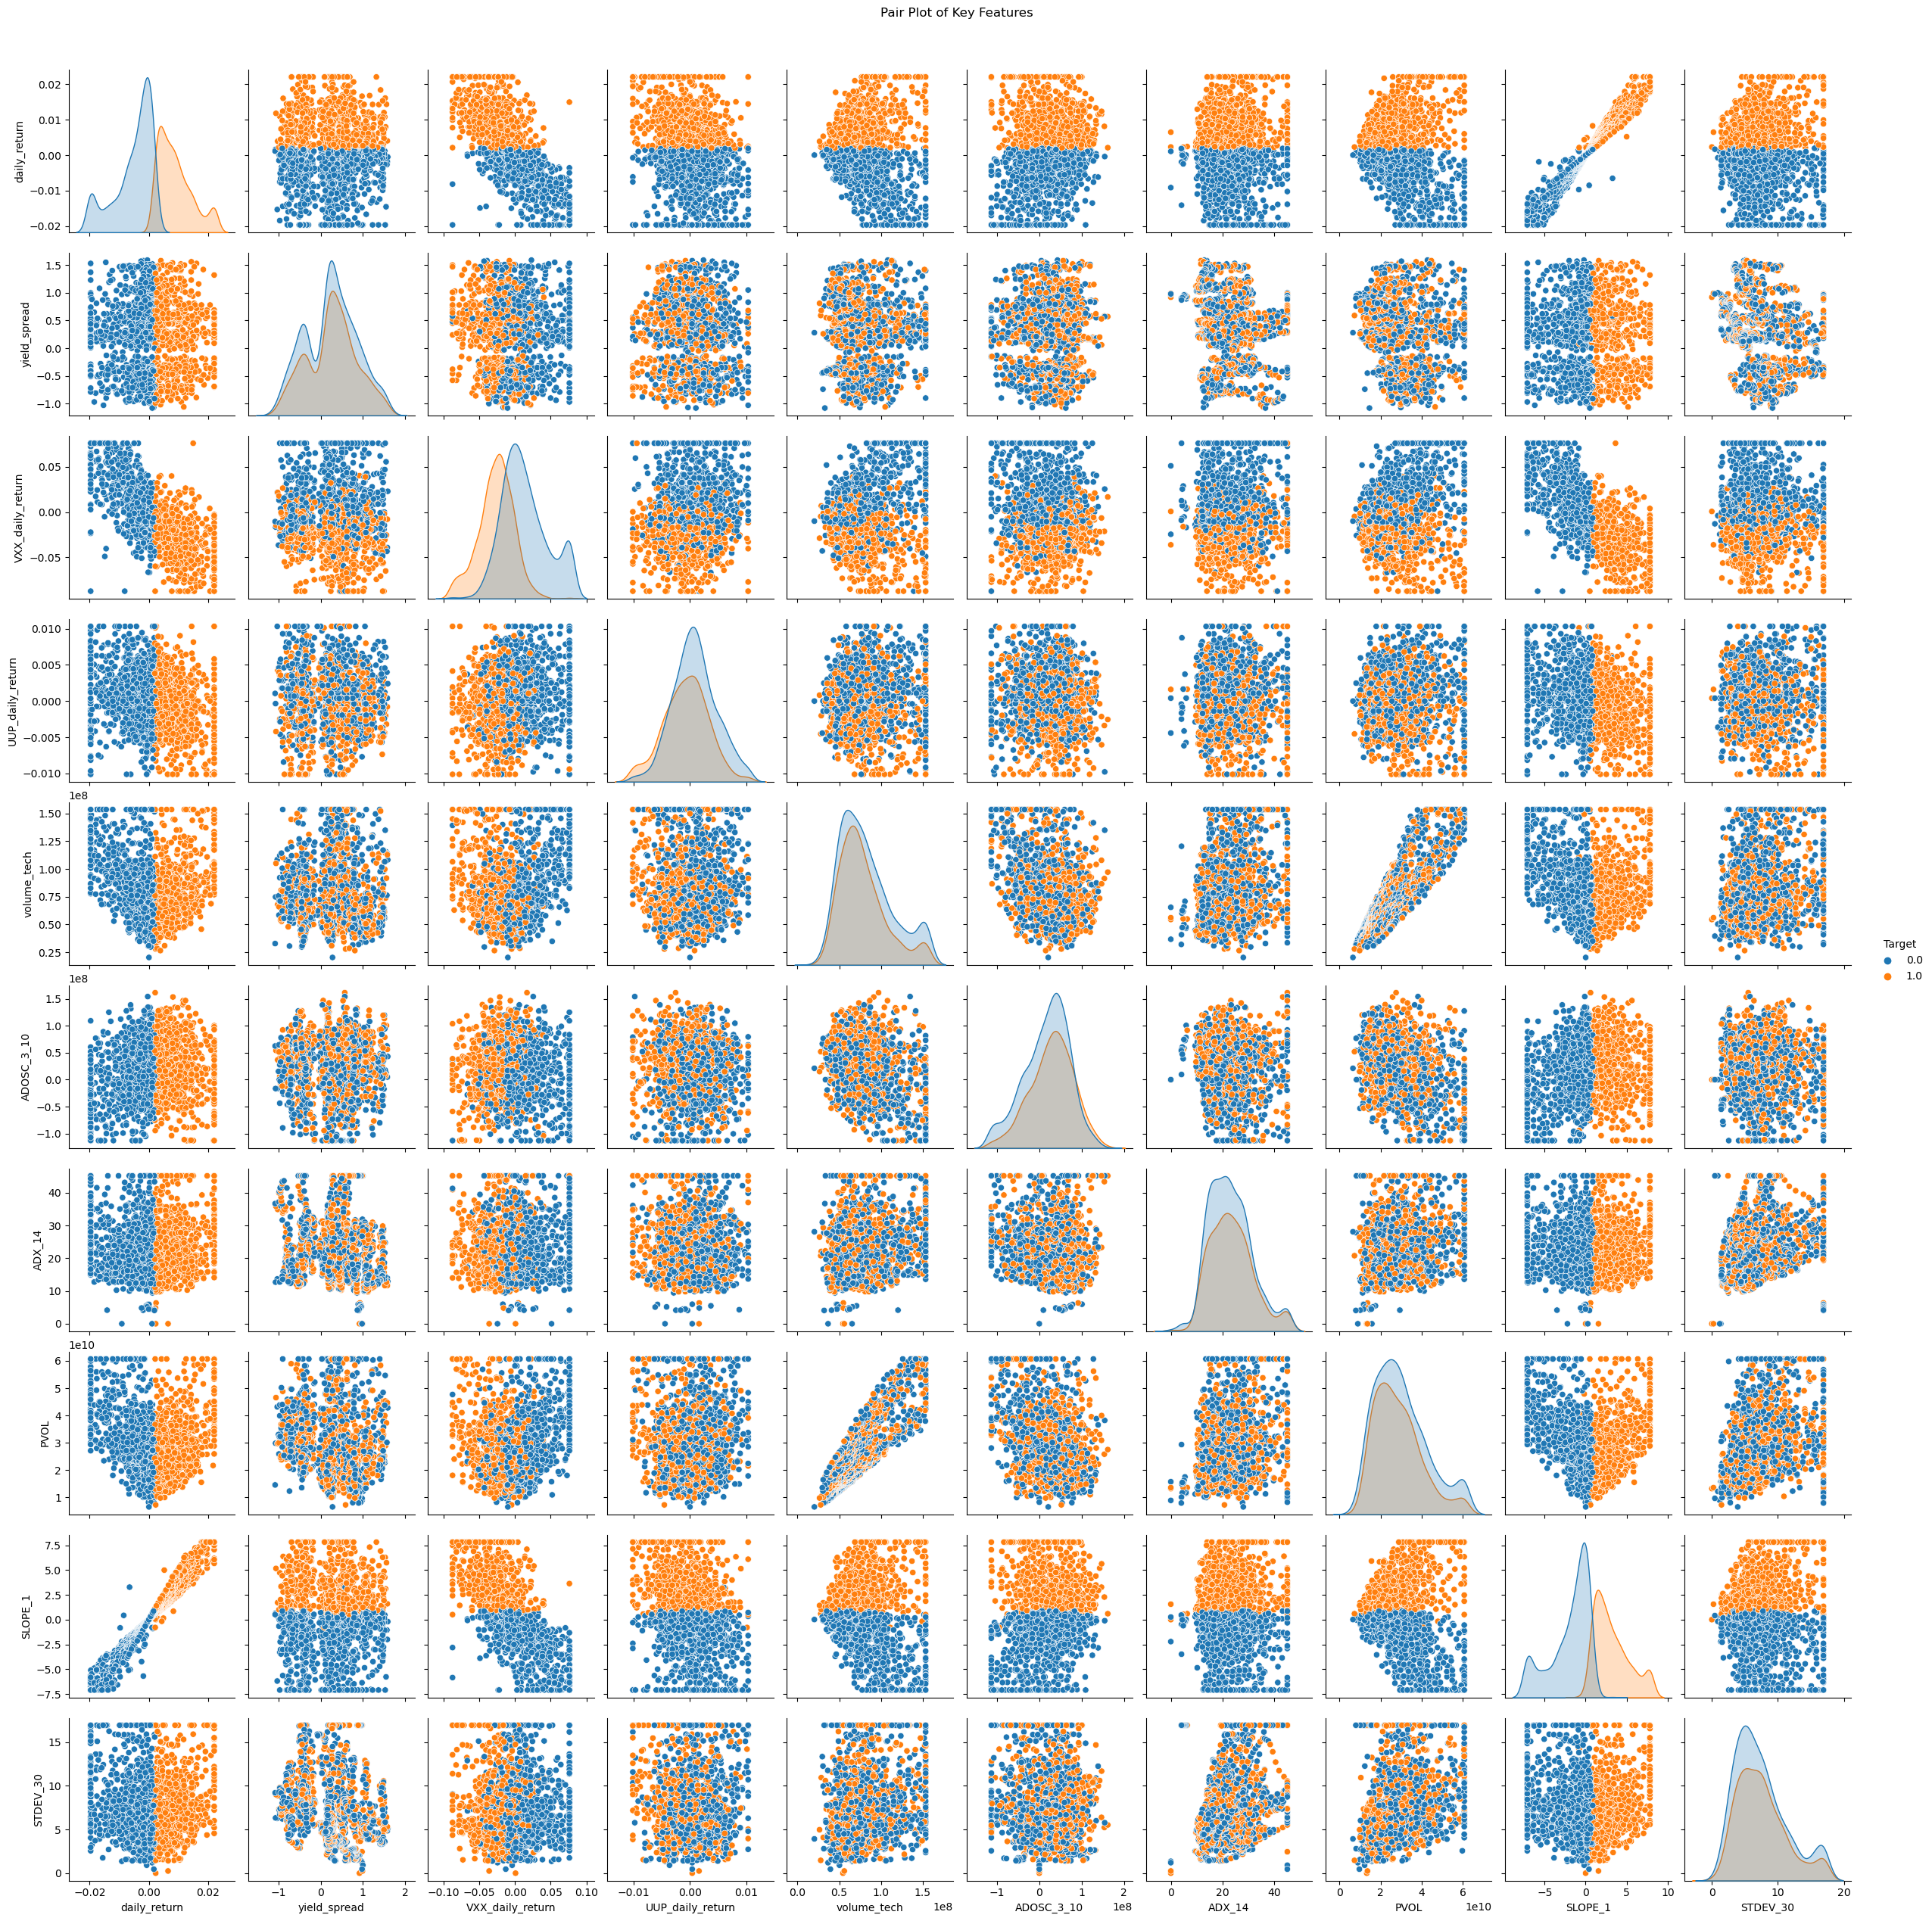

In [63]:
# Selecting a subset of relevant features for the pair plot
selected_features_for_plot = [
    'daily_return', 'yield_spread', 'VXX_daily_return', 'UUP_daily_return', 
    'volume_tech', 'ADOSC_3_10', 'ADX_14', 'PVOL', 'SLOPE_1','STDEV_30','Target', 
]

# Create a pairplot
sns.pairplot(df_capped[selected_features_for_plot], hue='Target', diag_kind='kde')
plt.suptitle('Pair Plot of Key Features', y=1.02) 
plt.show()

- Overlapping Features: In some scatter plots, the classes overlap significantly (e.g., VXX_daily_return vs. UUP_daily_return), suggesting these features alone may not provide strong predictive power.
- Separation in Specific Plots: Some feature pairs like SLOPE_1 and ADX_14 show better separation between the two classes, indicating these might be more influential in your model.
- Feature Distributions: The distributions of features like volume_tech show that while the classes overlap, there are distinct regions where one class is more prevalent.


#### Feature Importance with Random Forest

- Feature importance helps in understanding which features contribute the most to the model's predictions.
- By focusing on the most important features, we can build a more efficient and interpretable model, while potentially improving its performance.

- A Random Forest Classifier is initialized with 100 estimators (decision trees) and a random state for reproducibility.
- The model is trained on the training set to learn the relationship between the features and the target variable.

In [64]:
# Assuming your final dataset is stored in a DataFrame called `df_capped`
X = df_capped.drop('Target', axis=1)  # Features
y = df_capped['Target']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importance = feature_importance.sort_values(ascending=False)

# Display feature importance
print("Feature Importance:")
feature_importance

Feature Importance:


daily_return        0.342645
SLOPE_1             0.316032
DEC_1               0.116398
BBP_5_2.0           0.072061
BOP                 0.059199
VXX_daily_return    0.033216
CCI_14_0.015        0.009053
SMCtp_14_50_20_5    0.006360
PIVOTS_TRAD_D_R3    0.004287
PIVOTS_TRAD_D_P     0.004286
PDIST               0.003884
BULLP_13            0.003526
UUP_daily_return    0.003486
PVT                 0.003341
AOBV_SR_2           0.003206
volume_tech         0.003006
STDEV_30            0.002924
PVOL                0.002652
PSL_12              0.002055
ADOSC_3_10          0.002040
KVO_34_55_13        0.002014
yield_spread        0.001740
OBV                 0.001457
ADX_14              0.001131
dtype: float64

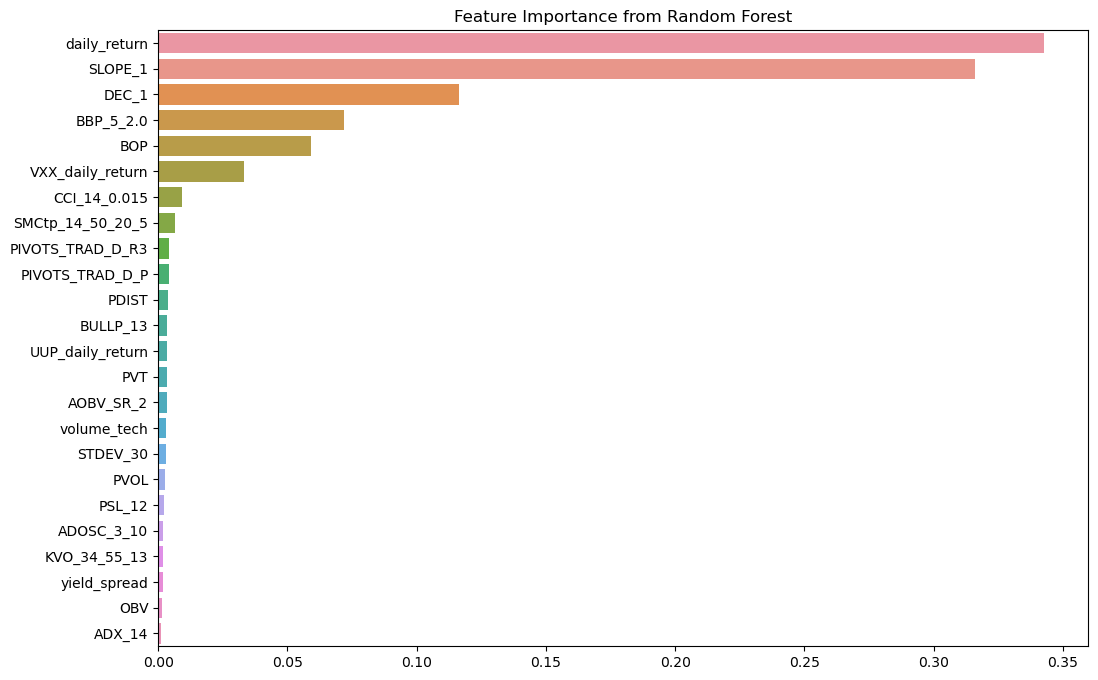

In [65]:
# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title("Feature Importance from Random Forest")
plt.show()

- **Output Interpretation:**
   - **Top Features:**
       - daily_return has the highest importance score of 0.3426, indicating that it is the most significant feature in predicting the target.
       - Other important features include SLOPE_1, DEC_1, and BBP_5_2.0, with importance scores of 0.3160, 0.1164, and 0.0721, respectively.

- **Importance of Visualization:**
      - The bar plot provides a clear visual ranking of features based on their importance, helping to identify which features are most influential in the model's decision-making process.
      - This analysis helps in understanding which features have the most impact on predicting the SPY ETF trend, allowing for more focused feature selection and potential dimensionality reduction in future model iterations

---

---